## Overview 

The increasing frequency and intensity of cyclonic rainfall events pose significant threats to insurance markets in climate-vulnerable coastal regions. For the World Bank Climate Risk Challenge, we presents a working prototype that integrates **quantum-enhanced risk forecasting** and **portfolio optimization** to address such challenges in coastal New Zealand.

We focus on **risk prediction** and **risk diversification**, developing a hybrid framework that leverages:

- A **Quantum Reuploading Unit (QRU)** for time-series rainfall forecasting,
- A **QAOA-based Conditional Value-at-Risk optimizer** for regional insurance allocation,
- A **smart parametric payout logic** for inclusive, fast-response insurance.

This notebook outlines the **technical implementation of the prototype**, simulation results, data-driven insights, and real-world stakeholder impact. It is designed as a proof-of-concept combining quantum innovation with scalable climate resilience.

---

- **Sabarikirishwaran Ponnambalam** – *Quantum Algorithms* (PhD, Griffith University)  
  Specialist in QAOA, Variational Circuits, Quantum Optimization.

- **Léa Cassé** – *Quantum Machine Learning & Environmental Data* (PhD, Univ. of Waikato / École Polytechnique)  
  Expertise: QRU-based models, forecasting, TAIAO project collaborator.

### 🌧️ Auckland Region – Eligible Rivers for Climate Risk Study


### Rivers either within Auckland or under its greater hydrological influence (e.g., Franklin, Hauraki Plains, Coromandel). All are **≥ 50 km** in length and **≥ 2 m** in depth.
---

- **Marokopa River – Falls <span style="color: red;"></span>** 
  • Depth: 2.25 m  
  • Region: Waikato / Auckland border  
  • Length: ~58 km  

- **Oraka Stream – Pinedale <span style="color: red;"></span>** 
  • Depth: 2.01 m  
  • Region: Northern Waikato (Auckland catchment)  
  • Length: ~50+ km (assumed)

- **Waikato River (multiple sites) <span style="color: red;"></span>**
  • Depths: 6.72 – 11.69 m  
  • Region: Hamilton → Auckland supply  
  • Length: 425 km  

- **Waipa River (Otewa, SH23, SH31)**  
  • Depths: 9.02 – 28.30 m  
  • Region: Waikato  
  • Length: 115 km  

- **Waihou River (Okauia, Te Aroha)**  
  • Depths: 2.38 – 7.35 m  
  • Region: Hauraki / Coromandel  
  • Length: ~150 km  

- **Ohinemuri River (Karangahake, Queens Head)**  
  • Depths: 2.80 – 5.84 m  
  • Region: Coromandel / Hauraki  
  • Length: ~70 km  

## Package installation

In [ ]:
!pip install --no-cache-dir torch torchvision torchaudio -q
!pip install --no-cache-dir pytorch-lightning -q
!pip install --no-cache-dir custatevec-cu12 -q
!pip install --no-cache-dir lightning pennylane-lightning-gpu -q
!pip install --no-cache-dir pandas matplotlib -q
!pip install --no-cache-dir "pennylane[jax]>=0.38" "jax[cpu]" pennylane-catalyst -q

In [ ]:
!pip uninstall flax orbax-checkpoint dopamine-rl tensorflow -y -q
!pip install flax==0.7.5 orbax-checkpoint==0.4.6 dopamine-rl==4.0.0 tensorflow==2.18.0 -q

In [ ]:
!pip install geopandas folium fiona shapely fuzzywuzzy[speedup] python-Levenshtein -q
!pip install mplleaflet jet rainbow turbo matplotlib-scalebar ipympl geopy contextily -q

## Data Preprocessing

In [11]:
import os
import io
import re
import gzip
import pandas as pd
import pennylane.numpy as np
from glob import glob
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter

data_str_date = '2019-10-21'

def impute_missing_with_average(series):
    """
    Impute missing values in a pandas Series by averaging the previous and next valid values.
    """
    series = series.copy()
    nan_indices = series[series.isna()].index

    for i in nan_indices:
        prev_idx = series.index[series.index.get_loc(i) - 1] if series.index.get_loc(i) > 0 else None
        next_idx = series.index[series.index.get_loc(i) + 1] if series.index.get_loc(i) < len(series) - 1 else None
        
        prev_val = series[prev_idx] if prev_idx is not None else np.nan
        next_val = series[next_idx] if next_idx is not None else np.nan
        
        if not np.isnan(prev_val) and not np.isnan(next_val):
            series.at[i] = (prev_val + next_val) / 2            
        elif not np.isnan(prev_val): # fallback
            series.at[i] = prev_val
        elif not np.isnan(next_val):
            series.at[i] = next_val
    return series


def load_weather_data(folder_path='.', datetime_format='%d-%b-%Y %H:%M'):
    """
    Load all .csv weather files (rainfall/wind) in folder_path.        
    """
    datasets = {}
    # headers
    expected_keywords = ['date', 'time', 'rain', 'wind']
    
    for file in glob(os.path.join(folder_path, '*.csv')):
        name = file.strip().replace('.csv','')
        name = re.sub(r'\s+', '', name)
        try:            
            with open(file, 'rt') as f:
                lines = f.readlines()
                            
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().split(" "))                
                if any(keyword in tokens for keyword in expected_keywords):
                    header_idx = idx
                    break                        
            
            # Load csv
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str,
                low_memory=False
            )
            
            # Parse datetime
            if 'date' in df.columns and 'time' in df.columns:
                df['datetime'] = pd.to_datetime(
                    df['date'] + ' ' + df['time'],
                    format=datetime_format,
                    errors='coerce'
                )
                df.drop(columns=['date', 'time'], inplace=True)                
            else:
                # fallback
                dt_col = next((col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()), None) 
                df['datetime'] = pd.to_datetime(df[dt_col], format=datetime_format, errors='coerce')                
                df.drop(columns=[dt_col], inplace=True)
                        
            rename_map = {}
            for c in df.columns:
                lc = c.lower()
                if 'rain' in lc: 
                    rename_map[c] = 'rainfall_mm'
                if 'wind' in lc and 'speed' in lc:
                    rename_map[c] = 'wind_speed_mps'
            df.rename(columns=rename_map, inplace=True)
            df['wind_speed_mps'] = df['wind_speed_mps'].str.strip().replace({'VRB': np.nan, 'NA': np.nan, 'NaN': np.nan, 'na': np.nan})
                        
            df = df[['datetime', 'rainfall_mm', 'wind_speed_mps']].copy()                        

            #Cast to numeric
            df['rainfall_mm'] = pd.to_numeric(df['rainfall_mm'], errors='coerce')
            df['wind_speed_mps'] = pd.to_numeric(df['wind_speed_mps'], errors='coerce')                    
            
            #impute missing values
            df['rainfall_mm'] = impute_missing_with_average(df['rainfall_mm'])
            df['wind_speed_mps'] = impute_missing_with_average(df['wind_speed_mps'])
            
            df = df.dropna(subset=['datetime', 'rainfall_mm', 'wind_speed_mps'])                                
            
            df = df.sort_values('datetime').reset_index(drop=True)
            start_date = pd.Timestamp(data_str_date)
            df = df[df['datetime'] >= start_date]

            df = (
                df
                .set_index('datetime')
                .resample('D')
                .agg({
                    'rainfall_mm': 'sum',       # total rain per day
                    'wind_speed_mps': 'mean',   # average wind per day
                })
                .reset_index()
            )
            df['date'] = df['datetime'].dt.date
            
            
            print(f"Weather loaded: {name} ({len(df)} rows)")
        
        except Exception as e:
            print(f"Skipping {name}: {e}")
            
    return df

def load_river_level_data(folder_path='.', river_sites=None, datetime_format='%Y-%m-%d %H:%M:%S'):
    """
    Load river level csv for specified river_sites.        
    """
    if river_sites is None:
        river_sites = ['waikato', 'waipa', '']
    datasets = {}
    expected_cols = ['date', 'time', 'wlvalue', 'flvalue']
    for file in glob(os.path.join(folder_path, '*.csv')) + glob(os.path.join(folder_path, '*.csv')):
        name = os.path.basename(file)
        
        if not any(site.lower() in name.lower() for site in river_sites):
            continue
        try:            
            opener = gzip.open if file.endswith('.gz') else open
            with opener(file, 'rt') as f:
                lines = f.readlines()
            
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().replace(',',' ').split())                
                if any(keyword in tokens for keyword in expected_cols):
                    header_idx = idx
                    break
                                
            df = pd.read_csv(
                io.StringIO(''.join(lines[header_idx:])),
                dtype=str, low_memory=False
            )            
                    
            if 'date' in df.columns and 'time' in df.columns:                
                df['dt'] = df['date'] + ' ' + df['time']                                
                df['datetime'] = pd.to_datetime(
                    df['dt'],
                    format=datetime_format,
                    errors='coerce'
                )                
                df.drop(columns=['date', 'time', 'dt'], inplace=True)                
                        
            df['river_level'] = df['wlvalue'].astype(float)
            # impute missing data
            df['river_level'] = impute_missing_with_average(df['river_level'])
            df = df.dropna(subset=['datetime', 'river_level'])
            df = df[['datetime', 'river_level']].sort_values('datetime')
            df = df.set_index('datetime')
            
            #resample data hourly
            #df = df.resample('h').ffill()  
            print(f"River loaded: {name} ({len(df)} rows)")
            datasets[name] = df
        except Exception as e:
            print(f"Skipping river {name}: {e}")
    return datasets

def merge_weather_and_river(weather_daily, river_df):
    # bring river datetime back as column + extract date
    river = river_df.reset_index()
    river['date'] = river['datetime'].dt.date
    
    # merge on the calendar date
    merged = pd.merge(
        weather_daily[['date','rainfall_mm','wind_speed_mps']],
        river[['date','river_level']],
        on='date',
        how='inner'
    )
    
    merged['date'] = pd.to_datetime(merged['date'])   
    merged.rename(columns={'date': 'datetime'}, inplace=True)
    return merged.set_index('datetime')

def visualize_merged_data(data, threshold=150, title='Merged Timeseries'):
    """
    Plot rainfall and river level with threshold line.
    """
    fig, ax1 = plt.subplots(figsize=(12,6))
    #ax1.plot(data['datetime'], data['rainfall_mm'], label='Rainfall (mm)', color='blue')
    ax1.plot(data.index,         data['rainfall_mm'], label='Rainfall (mm)', color='blue')
    ax1.set_xlabel('Datetime'); ax1.set_ylabel('Rainfall (mm)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')    
    
    ax2 = ax1.twinx()
    #ax2.plot(data['datetime'], data['river_level'], label='River Level (m)', color='green')
    ax2.plot(data.index,         data['river_level'], label='River Level (m)', color='green')
    ax2.set_ylabel('River Level (m)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    #fig.tight_layout()
    plt.title(title)
    fig.legend()
    plt.show()

# Load data
weather_data = load_weather_data(folder_path='/kaggle/input/wbcfull/rainfall_data')
river_data = load_river_level_data(folder_path='/kaggle/input/wbcfull/riverlevel_data', river_sites=['waikato','waipa', 'waihou'])
merged_data = {}

# Merge matching datasets
for rname, rdata in river_data.items():
    merged_data[rname] = merge_weather_and_river(weather_data, rdata)


key = next(iter(merged_data))
df_merge = merged_data[key]

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


Weather loaded: /kaggle/input/wbcfull/rainfall_data/Observations_Hourly_Auckland_Aerodrome_NZAAA_1993Jan01_2025May23 (2042 rows)
River loaded: River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv (2041 rows)
River loaded: RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv (2041 rows)
River loaded: River Level - Waihou River - Te Aroha - ADCP - 1st Jan 2019 - 23rd May 2025.csv (2041 rows)
River loaded: River Level - Waikato River - Ngaruawahia Cableway - 1st Jan 2019 - 23rd May 2025.csv (2041 rows)
River loaded: River Level - Waihou River - Okauia - 1st Jan 2019 - 23rd May 2025.csv (1900 rows)
River loaded: River Level - Waikato River - Huntly Power Station - 1st Jan 2019 - 23rd May 2025.csv (2041 rows)
River loaded: RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv (2041 rows)
River loaded: River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv (2041 rows)
River loaded: RiverLevel-WaipaRiver-Otewa-1stJan 19

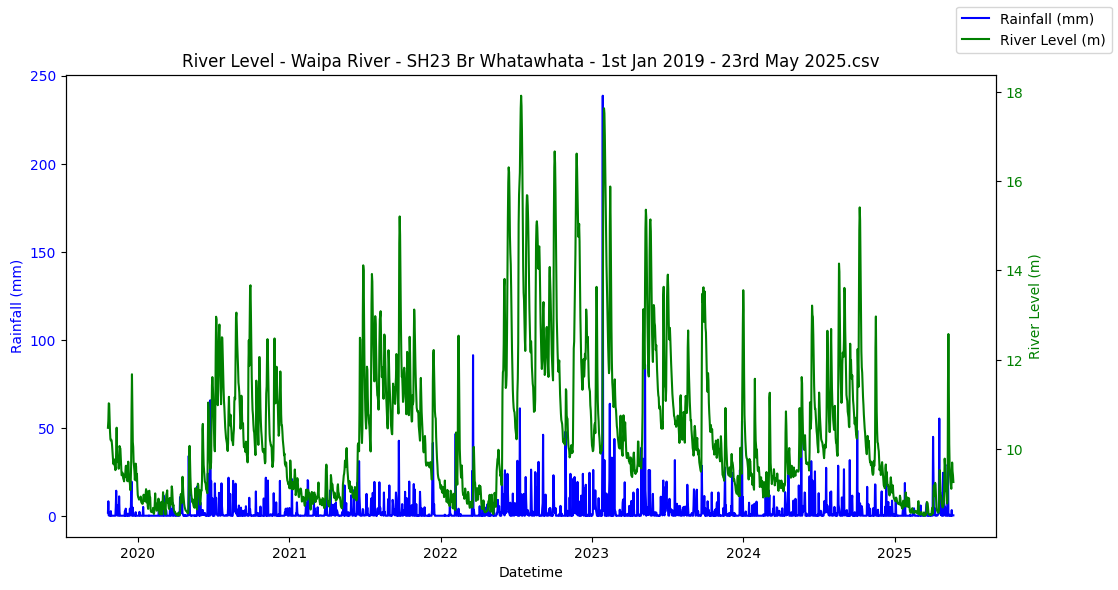

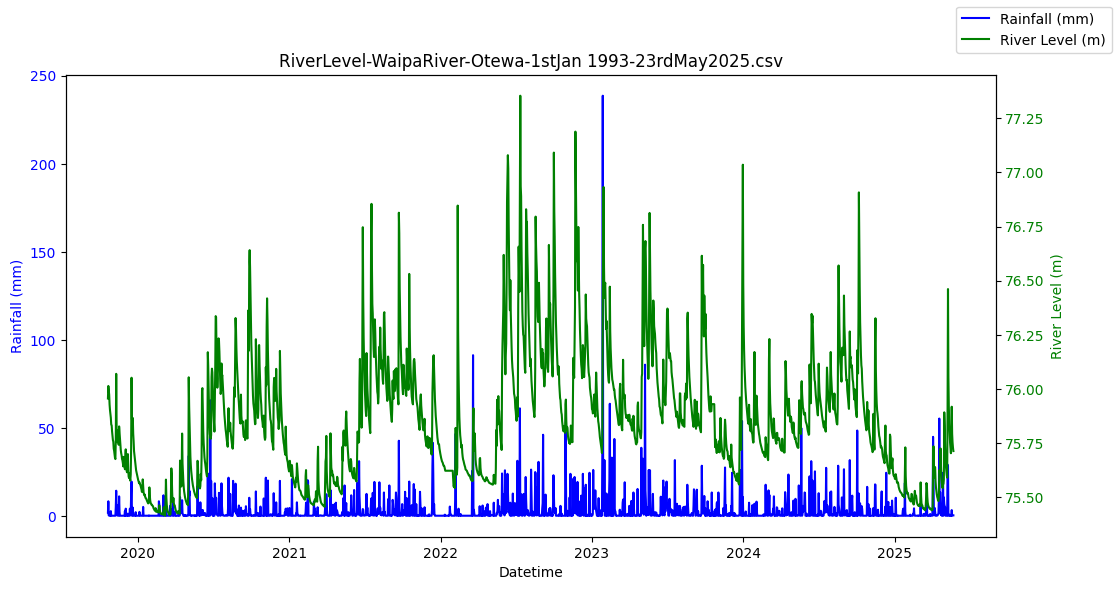

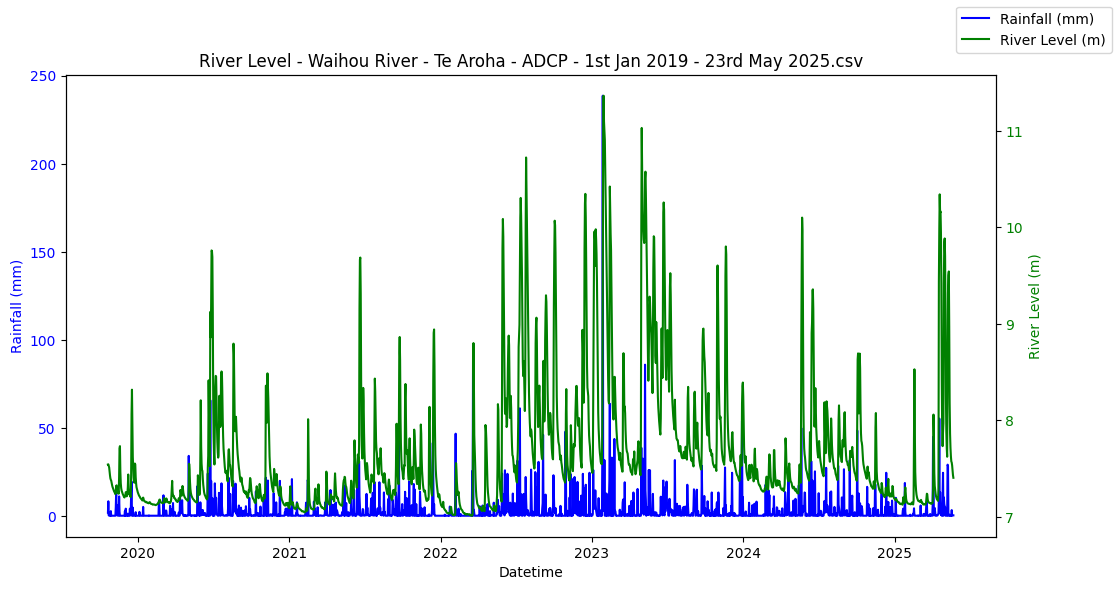

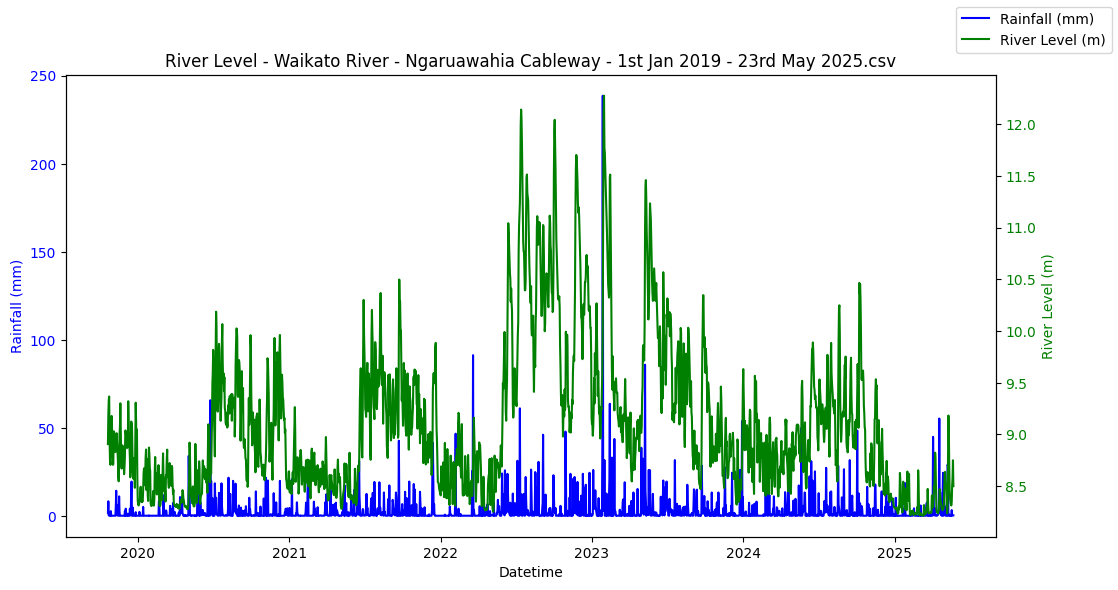

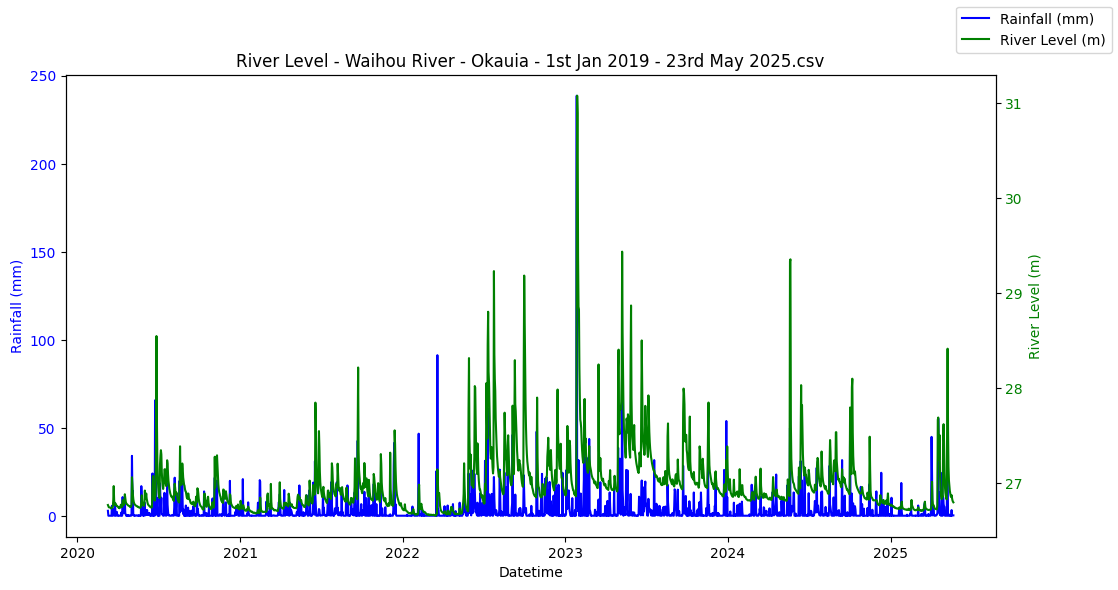

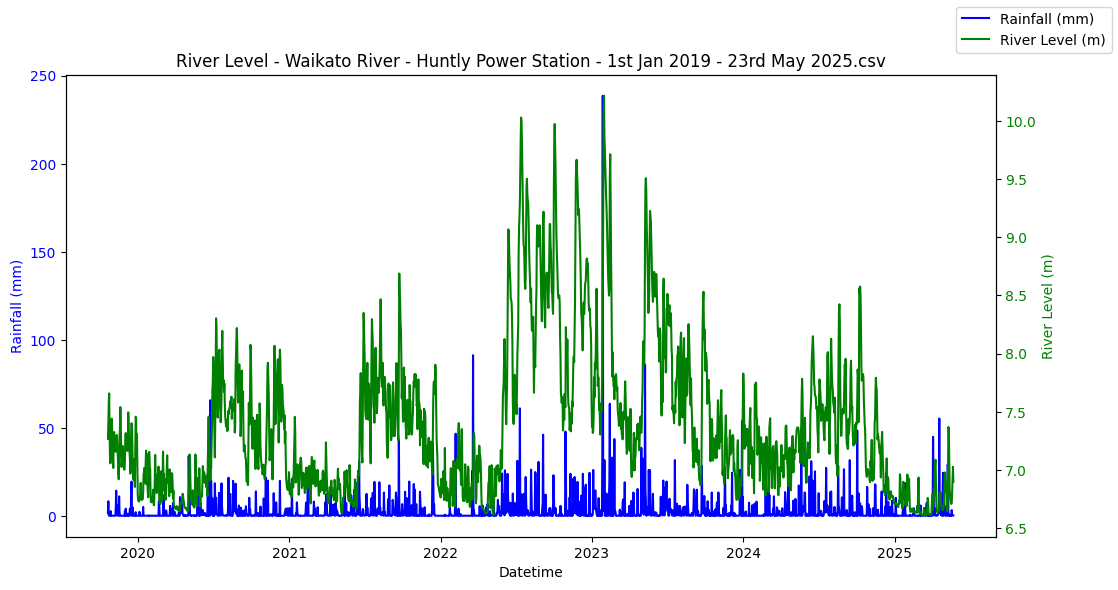

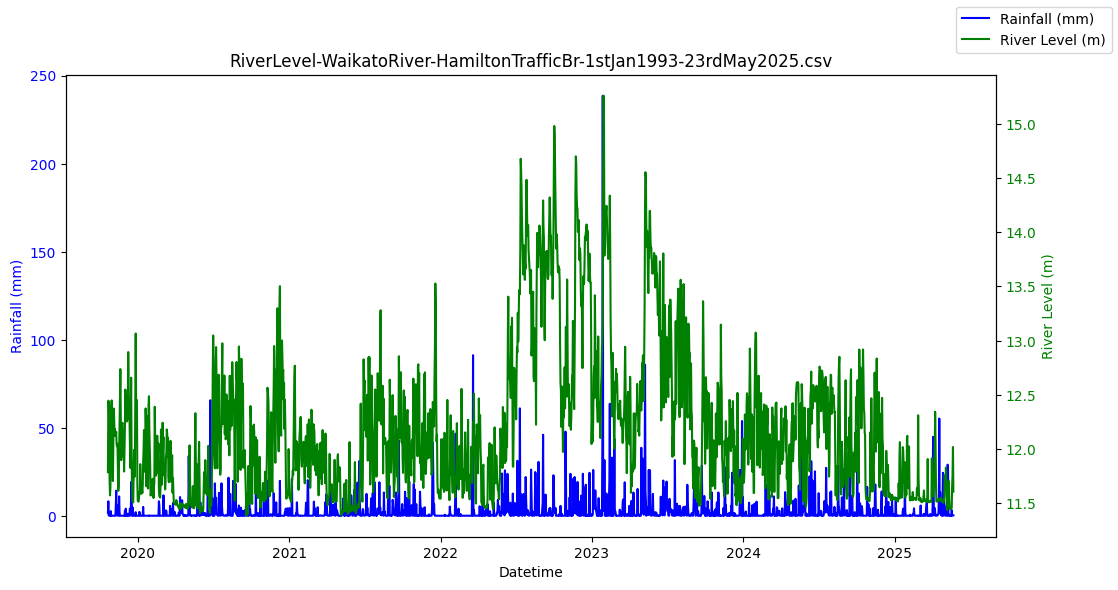

In [12]:
# Visualize
for key, df_merge in merged_data.items():    
    visualize_merged_data(df_merge, title=key)

In [13]:
print(merged_data.keys())
merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'].to_csv('hamilton_riverlevel.csv', index=False)
merged_data['RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv']

dict_keys(['River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv', 'RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv', 'River Level - Waihou River - Te Aroha - ADCP - 1st Jan 2019 - 23rd May 2025.csv', 'River Level - Waikato River - Ngaruawahia Cableway - 1st Jan 2019 - 23rd May 2025.csv', 'River Level - Waihou River - Okauia - 1st Jan 2019 - 23rd May 2025.csv', 'River Level - Waikato River - Huntly Power Station - 1st Jan 2019 - 23rd May 2025.csv', 'RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'])


,rainfall_mm,wind_speed_mps,river_level
datetime,,,
2019-10-21,1.8,9.283333,11.787
2019-10-22,8.2,10.762500,12.447
2019-10-23,0.2,9.904167,12.436
2019-10-24,1.4,10.795833,12.213
2019-10-25,0.0,8.879167,11.729
...,...,...,...
2025-05-18,3.2,4.908333,11.457
2025-05-19,0.0,5.891667,11.657
2025-05-20,0.2,2.254167,11.768


## QRU model for River Level Forecasting

## QRU-jax

In [ ]:
# -*- coding: utf-8 -*-
"""
QRU regression model accelerated with PennyLane-JAX + JAX/Adam

- Uses default.qubit (no default.qubit.jax required)
- JAX is used as the interface for differentiation
- Vectorized evaluation of the QNode with jax.vmap
- JAX-based Adam optimizer
"""

import os
import csv
import pandas as pd
import numpy as onp  # standard NumPy (non-differentiable)

import jax
import jax.numpy as jnp
import pennylane as qml
from dataclasses import dataclass

# ---------------------------------------------------------------------------
# Paths & hyperparameters
# ---------------------------------------------------------------------------
base_dir = "kaggle/working/"
river_site = "Waipa_River_SH23_Br_Whatawhata"
output_dir = base_dir + "output_" + river_site

os.makedirs(output_dir, exist_ok=True)

nb_reuploading = 4
window_size    = 6
n_epochs       = 300
batch_size     = 16

# Early stopping
patience  = 10
min_delta = 1e-4

# Optional: seed for reproducibility on NumPy side
onp.random.seed(42)

# ---------------------------------------------------------------------------
# Data loading & sliding windows
# ---------------------------------------------------------------------------

df = pd.read_csv(
    "/kaggle/input/wbcfull/seven_rivers_data/" + river_site + ".csv",
    parse_dates=["date"],
)

X_list, y_list, dates = [], [], []
for i in range(len(df) - window_size):
    w = df.iloc[i : i + window_size][["rainfall", "river_level"]].values
    X_list.append(w)
    y_list.append(df.iloc[i + window_size]["river_level"])
    dates.append(df.iloc[i + window_size]["date"])

# Convert to JAX arrays for training; keep dates as NumPy/pandas-friendly
X     = jnp.array(onp.array(X_list))  # (n_samples, window_size, 2)
y     = jnp.array(onp.array(y_list))  # (n_samples,)
dates = onp.array(dates)             # (n_samples,)

n   = X.shape[0]
t70 = int(0.7 * n)
v80 = int(0.8 * n)

X_train, y_train, dates_train = X[:t70],     y[:t70],    dates[:t70]
X_val,   y_val,   dates_val   = X[t70:v80],  y[t70:v80], dates[t70:v80]
X_test,  y_test,  dates_test  = X[v80:],     y[v80:],    dates[v80:]

# ---------------------------------------------------------------------------
# PennyLane device (no JAX-specific device, just default.qubit)
# ---------------------------------------------------------------------------

dev = qml.device("default.qubit", wires=1)

# ---------------------------------------------------------------------------
# QRU circuit & QNode (JAX interface)
# ---------------------------------------------------------------------------

def qru_circuit(features, thetas):
    """
    QRU circuit:
    - features: (window_size, 2) -> [rainfall, river_level]
    - thetas:   (nb_reuploading, window_size, 3)
                -> [theta_r, theta_z, theta_level]
    """
    for l in range(nb_reuploading):
        for i in range(window_size):
            r, lvl = features[i]
            th_r, th_z, th_l = thetas[l, i]
            qml.RX(th_r * r,   wires=0)
            qml.RZ(th_z,       wires=0)
            qml.RY(th_l * lvl, wires=0)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="jax")
def qnode(features, thetas):
    return qru_circuit(features, thetas)

# Vectorized over batch dimension of features
vmapped_qnode = jax.vmap(qnode, in_axes=(0, None))

# ---------------------------------------------------------------------------
# Loss, metrics, JAX-Adam
# ---------------------------------------------------------------------------

def cost_fn(thetas, X_batch, y_batch):
    """
    Mean squared error over a batch.
    thetas:  (nb_reuploading, window_size, 3)
    X_batch: (batch_size, window_size, 2)
    y_batch: (batch_size,)
    """
    preds = vmapped_qnode(X_batch, thetas)
    return jnp.mean((preds - y_batch) ** 2)

# JIT for speed
cost_and_grad = jax.jit(jax.value_and_grad(cost_fn))
cost_jit      = jax.jit(cost_fn)
grad_cost_jit = jax.jit(jax.grad(cost_fn))

def mae_accuracy(thetas, X_set, y_set, tol=0.1):
    preds = vmapped_qnode(X_set, thetas)
    return jnp.mean(jnp.abs(preds - y_set) <= tol)

def grad_norm(thetas, X_set, y_set):
    g = grad_cost_jit(thetas, X_set, y_set)
    return jnp.linalg.norm(g)

@dataclass
class AdamState:
    params: jnp.ndarray
    m: jnp.ndarray
    v: jnp.ndarray
    t: int

def init_adam(params):
    m = jnp.zeros_like(params)
    v = jnp.zeros_like(params)
    return AdamState(params=params, m=m, v=v, t=0)

def adam_update(state, grads, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8):
    m = beta1 * state.m + (1.0 - beta1) * grads
    v = beta2 * state.v + (1.0 - beta2) * (grads ** 2)
    t = state.t + 1

    m_hat = m / (1.0 - beta1 ** t)
    v_hat = v / (1.0 - beta2 ** t)

    params = state.params - lr * m_hat / (jnp.sqrt(v_hat) + eps)
    return AdamState(params=params, m=m, v=v, t=t)

# ---------------------------------------------------------------------------
# Metrics CSV
# ---------------------------------------------------------------------------

metrics_file = os.path.join(output_dir, "metrics_qru.csv")
with open(metrics_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(
        [
            "epoch",
            "train_mse",
            "train_acc",
            "train_gnorm",
            "val_mse",
            "val_acc",
            "val_gnorm",
        ]
    )

# ---------------------------------------------------------------------------
# Training loop with early stopping
# ---------------------------------------------------------------------------

thetas_init = jnp.full((nb_reuploading, window_size, 3), 0.5)
opt_state   = init_adam(thetas_init)

best_val_loss     = float("inf")
epochs_no_improve = 0
best_thetas       = thetas_init

for epoch in range(1, n_epochs + 1):
    # Shuffle indices (NumPy for convenience)
    perm = onp.random.permutation(int(X_train.shape[0]))
    Xs   = X_train[perm]
    ys   = y_train[perm]

    # Mini-batch updates
    for i in range(0, X_train.shape[0], batch_size):
        Xb = Xs[i : i + batch_size]
        yb = ys[i : i + batch_size]
        loss_batch, grads = cost_and_grad(opt_state.params, Xb, yb)
        opt_state = adam_update(opt_state, grads, lr=1e-3)

    thetas = opt_state.params

    # Full-set metrics (train & val)
    tr_mse   = cost_jit(thetas, X_train, y_train)
    tr_acc   = mae_accuracy(thetas, X_train, y_train)
    tr_gnorm = grad_norm(thetas, X_train, y_train)

    vl_mse   = cost_jit(thetas, X_val, y_val)
    vl_acc   = mae_accuracy(thetas, X_val, y_val)
    vl_gnorm = grad_norm(thetas, X_val, y_val)

    with open(metrics_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(
            [
                epoch,
                float(tr_mse),
                float(tr_acc),
                float(tr_gnorm),
                float(vl_mse),
                float(vl_acc),
                float(vl_gnorm),
            ]
        )

    print(
        f"Epoch {epoch:03d}/{n_epochs} | "
        f"Train MSE={float(tr_mse):.6f}, Acc={float(tr_acc):.4f}, ‖∇‖={float(tr_gnorm):.6f} | "
        f" Val MSE={float(vl_mse):.6f}, Acc={float(vl_acc):.4f}, ‖∇‖={float(vl_gnorm):.6f}"
    )

    # Early stopping
    if best_val_loss - float(vl_mse) > min_delta:
        best_val_loss     = float(vl_mse)
        epochs_no_improve = 0
        best_thetas       = jnp.array(thetas)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(
            f"Early stopping: patience {patience} epochs "
            f"(val_loss = {best_val_loss:.6f}). epoch {epoch}."
        )
        break

thetas_final = best_thetas

# ---------------------------------------------------------------------------
# Save params
# ---------------------------------------------------------------------------

params_path = os.path.join(output_dir, "qru_thetas_trained.npy")
onp.save(params_path, onp.array(thetas_final))
print(f"Params saved to '{params_path}'")

# ---------------------------------------------------------------------------
# Inference & predictions CSV
# ---------------------------------------------------------------------------

def get_preds(X_set, thetas):
    preds = vmapped_qnode(X_set, thetas)  # JAX array
    return onp.array(preds)               # convert to NumPy for pandas

preds_train = get_preds(X_train, thetas_final)
preds_val   = get_preds(X_val,   thetas_final)
preds_test  = get_preds(X_test,  thetas_final)

df_train = pd.DataFrame(
    {
        "date":   dates_train,
        "set":    ["train"] * len(dates_train),
        "y_true": onp.array(y_train),
        "y_pred": preds_train,
    }
)
df_val = pd.DataFrame(
    {
        "date":   dates_val,
        "set":    ["val"] * len(dates_val),
        "y_true": onp.array(y_val),
        "y_pred": preds_val,
    }
)
df_test = pd.DataFrame(
    {
        "date":   dates_test,
        "set":    ["test"] * len(dates_test),
        "y_true": onp.array(y_test),
        "y_pred": preds_test,
    }
)

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
predictions_file = os.path.join(output_dir, "predictions.csv")
df_all.to_csv(predictions_file, index=False)
print(f"Predictions saved to '{predictions_file}'")

# LSTM

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# ----------------------------------------------------------------------
# Make TensorFlow use CPU only (avoid conflict with JAX on GPU in Kaggle)
# ----------------------------------------------------------------------
try:
    tf.config.set_visible_devices([], 'GPU')
    print("TensorFlow will use CPU only.")
except Exception as e:
    print("Could not restrict TF to CPU only:", e)

# ----------------------------------------------------------------------
# Hyperparameters
# ----------------------------------------------------------------------
window_size = 6
hidden_size = 3          # chosen so LSTM params = 72 (matches QRU)
batch_size  = 16
n_epochs    = 100        # max epochs; EarlyStopping will pick best < = 100
tol         = 0.1

output_dir = "/kaggle/working/output_simple_lstm"
os.makedirs(output_dir, exist_ok=True)

# NOTE: For a fair comparison with QRU, use the SAME river CSV as QRU.
# You can change this path to e.g. "Waikato_River_Huntly_Power_Station.csv"
df = pd.read_csv(
    "/kaggle/input/wbcfull/seven_rivers_data/Waihou_River_Okauia.csv",
    parse_dates=["date"]
)

# ----------------------------------------------------------------------
# Build sliding-window dataset
# ----------------------------------------------------------------------
X, y = [], []
for i in range(len(df) - window_size):
    seq = df.iloc[i : i + window_size][["rainfall", "river_level"]].values
    X.append(seq)
    y.append(df.iloc[i + window_size]["river_level"])

X = np.array(X, dtype=np.float32)  # (n_samples, window_size, 2)
y = np.array(y, dtype=np.float32)  # (n_samples,)

n   = len(X)
i70 = int(0.7 * n)
i80 = int(0.8 * n)

X_train, y_train = X[:i70],     y[:i70]
X_val,   y_val   = X[i70:i80],  y[i70:i80]
X_test,  y_test  = X[i80:],     y[i80:]

print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

# ----------------------------------------------------------------------
# Model definition
# LSTM (72 params) + sum over hidden (no extra params) => matches QRU capacity
# ----------------------------------------------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(hidden_size, input_shape=(window_size, 2)),
    tf.keras.layers.Lambda(lambda h: tf.reduce_sum(h, axis=1))  # (batch, hidden) -> (batch,)
])

def acc_within_tol(y_true, y_pred):
    """Fraction of predictions within |y_pred - y_true| <= tol."""
    return tf.reduce_mean(tf.cast(tf.abs(y_pred - y_true) <= tol, tf.float32))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[acc_within_tol]
)

model.summary()

# ----------------------------------------------------------------------
# EarlyStopping callback (match QRU's patience/min_delta logic)
# ----------------------------------------------------------------------
callback_es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True
)

# ----------------------------------------------------------------------
# Training
# ----------------------------------------------------------------------
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[callback_es]
)

# ----------------------------------------------------------------------
# Save weights
# ----------------------------------------------------------------------
weights_path = os.path.join(output_dir, "simple_lstm.weights.h5")
model.save_weights(weights_path)
print(f"\nWeights saved to '{weights_path}'")

# ----------------------------------------------------------------------
# Save metrics history
# ----------------------------------------------------------------------
metrics_df = pd.DataFrame({
    "epoch":      np.arange(1, len(history.history["loss"]) + 1),
    "train_loss": history.history["loss"],
    "train_acc":  history.history["acc_within_tol"],
    "val_loss":   history.history["val_loss"],
    "val_acc":    history.history["val_acc_within_tol"],
})
metrics_csv = os.path.join(output_dir, "metrics.csv")
metrics_df.to_csv(metrics_csv, index=False)
print(f"Metrics (loss & accuracy) saved to '{metrics_csv}'")

# ----------------------------------------------------------------------
# Test predictions
# ----------------------------------------------------------------------
preds_test = model.predict(X_test)

preds_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": preds_test.flatten()
})
preds_csv = os.path.join(output_dir, "predictions.csv")
preds_df.to_csv(preds_csv, index=False)
print(f"Test predictions saved to '{preds_csv}'")

## Calculate Risk Score from the forecasted data

In [21]:
import os
import pandas as pd
import numpy as np
import io
from glob import glob

# -------------------------------------------------------------------------
# 1. Load historical stats per site (median, 5per, 95per)
# -------------------------------------------------------------------------

def load_hist_stats_data(folder_path, datetime_format='%Y-%m-%d'):
    """
    Load cleaned historical statistics CSVs with headers and correct datetime parsing.
    Returns: {site_name_raw: DataFrame(date -> [median, 5per, 95per])}
    """
    datasets = {}
    expected_cols = {"date", "median", "95per"}

    for file in glob(os.path.join(folder_path, "*.csv")):
        name = os.path.basename(file).replace(".csv", "")
        try:
            with open(file, "r") as f:
                lines = f.readlines()

            # Find the header
            header_idx = 0
            for idx, line in enumerate(lines):
                tokens = set(line.strip().lower().replace(",", " ").split())
                if expected_cols & tokens:
                    header_idx = idx
                    break

            df = pd.read_csv(io.StringIO("".join(lines[header_idx:])), dtype=str)
            df.columns = ["dateTime", "date", "median", "min", "max", "5per", "95per", "mean"]
            df["date"] = pd.to_datetime(df["date"], format=datetime_format, errors="coerce").dt.date
            df = df.dropna(subset=["date", "median", "95per"])
            df = df.set_index("date").sort_index()

            for col in ["median", "5per", "95per"]:
                if col in df.columns:
                    df[col] = df[col].astype(float)
                else:
                    df[col] = np.nan

            df = df[["median", "5per", "95per"]]
            datasets[name] = df
        except Exception as e:
            print(f"Failed to load: {name} — {e}")
            
    return datasets

# -------------------------------------------------------------------------
# 2. Linear risk on [p5, p95] band
# -------------------------------------------------------------------------

def band_risk_linear(pred_value, p5, p95):
    """
    Linear risk between p5 and p95:
      - pred <= p5  -> risk = 0
      - pred >= p95 -> risk = 1
      - else        -> (pred - p5) / (p95 - p5)
    """
    if p95 <= p5 or np.isnan(p95) or np.isnan(p5):
        return 0.0

    norm = (pred_value - p5) / (p95 - p5)
    return float(np.clip(norm, 0.0, 1.0))

# -------------------------------------------------------------------------
# 3. Risk function factory using daily or yearly p5/p95
# -------------------------------------------------------------------------

def make_risk_function(df_hist):
    """
    compute_flood_risk(pred_date, predicted_level):

      1. If pred_date in df_hist.index:
           use its daily (p5, p95).
      2. Else:
           use that year's average (p5, p95) if available,
           otherwise overall average (p5, p95).

    Risk is band_risk_linear(pred, p5, p95).
    """
    df_local = df_hist.copy()
    df_local["year"] = pd.DatetimeIndex(df_local.index).year

    # Per-year averages
    per_year_stats = {}
    for year, df_y in df_local.groupby("year"):
        per_year_stats[year] = {
            "p5":  df_y["5per"].mean(),
            "p95": df_y["95per"].mean(),
        }

    # Global stats
    global_stats = {
        "p5":  df_local["5per"].mean(),
        "p95": df_local["95per"].mean(),
    }

    def compute_flood_risk(pred_date, predicted_level):
        ts = pd.to_datetime(pred_date).date()

        if ts in df_hist.index:
            p5  = df_hist.loc[ts, "5per"]
            p95 = df_hist.loc[ts, "95per"]
        else:
            year = ts.year
            stats = per_year_stats.get(year, global_stats)
            p5  = stats["p5"]
            p95 = stats["p95"]

        return band_risk_linear(predicted_level, p5, p95)

    return compute_flood_risk

# -------------------------------------------------------------------------
# 4. Helper: canonical site key (matches your QRU output directory naming)
# -------------------------------------------------------------------------

def canonical_site_key(raw_name):
    return (
        raw_name
        .replace(" - ", "_")
        .replace("-", "_")
        .replace(" ", "_")
        .replace("River_Levels_", "")
        .strip()
    )

# -------------------------------------------------------------------------
# 5. Load historical data + build risk_functions per site
# -------------------------------------------------------------------------

hist_folder_path = "/kaggle/input/wbcfull/hist_data"
hist_data_dict   = load_hist_stats_data(hist_folder_path)

risk_functions = {
    site_raw: make_risk_function(df_hist)
    for site_raw, df_hist in hist_data_dict.items()
}

# -------------------------------------------------------------------------
# 6. Load QRU predictions and compute risk scores per site
# -------------------------------------------------------------------------

qru_output_root = "/kaggle/working/kaggle/working"
target_date_str = "2022-11-22"  # try a few different dates after this

risk_scores = {}

for site_raw, risk_fn in risk_functions.items():
    clean_name = canonical_site_key(site_raw)

    pred_dir = os.path.join(qru_output_root, f"output_{clean_name}")
    pred_csv = os.path.join(pred_dir, "predictions.csv")

    if not os.path.exists(pred_csv):
        print(f"Warning: predictions.csv not found for site '{clean_name}' at {pred_csv} — skipping.")
        continue

    preds_df = pd.read_csv(pred_csv, parse_dates=["date"])
    preds_df["date_only"] = preds_df["date"].dt.date

    target_date = pd.to_datetime(target_date_str).date()
    rows = preds_df.loc[preds_df["date_only"] == target_date]

    if rows.empty:
        print(f"Warning: no QRU prediction for site '{clean_name}' on {target_date} — skipping.")
        continue

    pred_level = float(rows["y_pred"].mean())

    risk_val = risk_fn(target_date_str, pred_level)
    risk_scores[clean_name] = risk_val

print("\nRisk scores (from QRU predictions) for", target_date_str)
for site, r in risk_scores.items():
    print(f"  {site}: {r:.3f}")



Risk scores (from QRU predictions) for 2022-11-22
  Waipa_River_SH23_Br_Whatawhata: 0.000
  Waipa_River_Otewa: 0.000
  Waihou_River_Te_Aroha_ADCP: 0.000
  Waihou_River_Okauia: 0.000
  Waikato_River_Huntly_Power_Station: 0.000
  Waikato_River_Hamilton_Traffic_Br: 0.000
  Waikato_River_Ngaruawahia_Cableway: 0.000


In [ ]:
k = target_date

In [ ]:
l = preds_df["date_only"]
preds_df.loc[k==l]

## Constructing Correlation Matrix

### GeoLocal Information

### 📍 Site Classification: Climate Vulnerability and Underserved Population 

| Site                  | River   | Type        | Climate Vulnerable? | Insurance Underserved? | Notes                                                                                                 |
| --------------------- | ------- | ----------- | ------------------- | ---------------------- | ----------------------------------------------------------------------------------------------------- |
| **HamiltonTrafficBr** | Waikato | Urban       | No                  | No                     | Major city with developed infrastructure, minimal agricultural activity, and strong insurer presence. |
| **Huntly**            | Waikato | Rural       | Yes                 | Yes                    | Flood-prone; agriculturally dependent; lower income; limited insurer interest.                        |
| **Rangiriri**         | Waikato | Rural       | Yes                 | Yes                    | Low-lying floodplain; high agricultural exposure; limited emergency services.                         |
| **SH23 (Whatawhata)** | Waipa   | Semi-Urban  | Moderate            | Yes                    | Fringe area; some agricultural presence; moderate risk; often falls into insurance gray zones.        |
| **Otewa**             | Waipa   | Rural       | Yes                 | Yes                    | Remote rural area with strong agricultural dependence and high flood risk.                            |
| **Te Aroha**          | Waihou  | Small Urban | Moderate-High       | Yes                    | Flood-prone small town with some agricultural dependence; moderate adaptive capacity.                 |
| **Okauia**            | Waihou  | Rural       | Yes                 | Yes                    | Rural, agriculture-based community; frequent flooding; minimal insurance coverage options.            |

---

### 🧭 Site Selection Criteria and Justification

* The selected sites along the **Waikato, Waipa, and Waihou rivers** in the greater Auckland region were chosen to evaluate geolocations that are both:

  * **Climate-vulnerable**, and
  * **Underserved by insurance services**

#### Selection was based on four criteria:

1. **Climate Risk Exposure**

   * Proximity to flood-prone rivers
   * Historical flood frequency as reported by **NIWA** and the **Waikato Regional Council**

2. **Socioeconomic Profile**

   * Population size, affluence, urban–rural classification
   * **Agricultural dependence** as a primary livelihood

3. **Market Attractiveness for Insurers**

   * Low population density and high climate risk result in:

     * Low insurance premiums
     * High liability
   * These factors make such locations less viable for traditional insurance offerings

4. **Infrastructure Quality and Emergency Response Capacity**

   * Presence (or absence) of flood mitigation systems
   * Local disaster preparedness and recovery resources

#### Supporting Evidence:

* According to New Zealand’s NIWA Flood Risk Assessment and Waikato Regional Council reports, seettlements at **Otewa**, **Okauia**, **Ngaruawahia**, and **Huntly** are located in low-lying floodplains with **recurrence intervals of 5–10 years** for riverine flooding.

* These rural communities rely heavily on **agriculture**, making them doubly exposed:

  * Physically, due to flooding
  * Economically, due to disruption of agricultural livelihoods

* These sites are often **overlooked by traditional insurance markets** due to low returns and high risks.

* Urban and semi-urban locations such as **HamiltonTrafficBr**, **Te Aroha**, and **SH23 (Whatawhata)** were included to provide a comparative perspective:

  * These locations have relatively higher infrastructure capacity
  * However, **some still experience varying levels of insurance underservice**, especially when infrastructure is outdated or exposure remains high

---

### ⚙️ Prototype Deployment

* A **limited number of sites** were selected for the **prototype demonstration** here in phase 3 due to time and computational constraints.
* The proposed solution is **scalable** and can be expanded to a **larger set of sites in the future**


In [ ]:
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
from time import sleep

shapefile_path = "/kaggle/input/wbcfull/map_data/lds-nz-river-centrelines-topo-1500k-SHP/nz-river-centrelines-topo-1500k.shp"
rivers_gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

site_metadata = {
    "HamiltonTrafficBr": {
        "location": "victoria bridge, New Zealand",
        "river": "Waikato",
        "type": "Urban",
        "climate_vulnerable": "No",
        "insurance_underserved": "No"
    },
    "Huntly": {
        "location": "Huntly, New Zealand",
        "river": "Waikato",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
    "Ngaruawahia": {
        "location": "Ngaruawahia, New Zealand",
        "river": "Waikato",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
    "SH23": {
        "location": "SH23, Whatawhata, New Zealand",
        "river": "Waipa",
        "type": "Semi-Urban",
        "climate_vulnerable": "Moderate",
        "insurance_underserved": "Yes"
    },
    "Otewa": {
        "location": "Otewa, New Zealand",
        "river": "Waipa",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
    "Te Aroha": {
        "location": "Te Aroha, New Zealand",
        "river": "Waihou",
        "type": "Small Urban",
        "climate_vulnerable": "Moderate-High",
        "insurance_underserved": "Yes"
    },
    "Okauia": {
        "location": "Okauia, New Zealand",
        "river": "Waihou",
        "type": "Rural",
        "climate_vulnerable": "Yes",
        "insurance_underserved": "Yes"
    },
}

geolocator = Nominatim(user_agent="nz-river-mapper")
site_points = []

for site, info in site_metadata.items():
    try:
        location = geolocator.geocode(info["location"], timeout=10)
        if location:
            site_points.append({
                "name": site,
                "river": info["river"],
                "type": info["type"],
                "climate_vulnerable": info["climate_vulnerable"],
                "insurance_underserved": info["insurance_underserved"],
                "lat": location.latitude,
                "lon": location.longitude
            })
        else:
            print(f"Failed to locate: {info['location']}")
        sleep(1)
    except Exception as e:
        print(f"Error for {site}: {e}")

sites_gdf = gpd.GeoDataFrame(
    site_points,
    geometry=gpd.points_from_xy(
        [s["lon"] for s in site_points], [s["lat"] for s in site_points]),
    crs="EPSG:4326"
)

m = folium.Map(location=[-37.5, 175.5], zoom_start=8, tiles="CartoDB positron")

for _, row in rivers_gdf.iterrows():
    if row.geometry and row.geometry.is_valid:
        geo_json = gpd.GeoSeries([row.geometry]).simplify(0.001).to_json()
        folium.GeoJson(
            data=geo_json,
            style_function=lambda x: {
                'color': 'blue',
                'weight': 1.5,
                'opacity': 0.5
            }
        ).add_to(m)

for _, row in sites_gdf.iterrows():
    if row["climate_vulnerable"] == "Yes" and row["insurance_underserved"] == "Yes":
        color = "red"
    elif "Moderate" in row["climate_vulnerable"] or row["insurance_underserved"] == "Yes":
        color = "orange"
    else:
        color = "green"

    # Circle marker
    folium.CircleMarker(
        location=(row["lat"], row["lon"]),
        radius=40,
        popup=folium.Popup(
            f"<b>{row['name']}</b><br><b>Type:</b> {row['type']}<br><b>Risk:</b> {row['climate_vulnerable']}<br><b>Underserved:</b> {row['insurance_underserved']}",
            max_width=300),
        color=color,
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

    # Label with site name
    folium.map.Marker(
        [row["lat"], row["lon"]],
        icon=folium.DivIcon(
            icon_size=(150, 36),
            icon_anchor=(0, 0),
            html=f'<div style="font-size: 12px; color: black;">{row["name"]}</div>',
        )
    ).add_to(m)

legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 220px; height: 120px; 
     background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
     padding: 10px;">
  <b>Legend – Site Risk & Insurance Status</b><br>
  <i style="background:red; width:12px; height:12px; display:inline-block;"></i> High Risk & Underserved<br>
  <i style="background:orange; width:12px; height:12px; display:inline-block;"></i> Moderate/Partial Risk<br>
  <i style="background:green; width:12px; height:12px; display:inline-block;"></i> Low Risk & Covered
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m.save("nz_river_sites_map.html")
print("Map saved as `nz_river_sites_map.html`")
#m

# Flooding Risk Visualizations

## Interactive Map with Risk Category and Map Layers

Following interactive map categorizes the risk prone regions into three categories - High, Medium and Low as identified by the Waikato Regional Council. Further Map is designed to toggle between different layers.

ARCGIS Data-source: https://waikatoregion.maps.arcgis.com/apps/MapSeries/index.html?appid=f2b48398f93146e8a5cf0aa3fddce92c

In [ ]:
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip

try:
    # Load Hazard Shapefile
    hazard_shp_path = "/kaggle/input/wbcfull/Regional_Flood_Hazard_Update_-1845110499191811799/HAZ_REGIONAL_FLOOD_HAZARD.shp"
    gdf = gpd.read_file(hazard_shp_path)

    # Load Rivers Shapefile
    rivers_shp_path = "/kaggle/input/wbcfull/map_data/lds-nz-river-centrelines-topo-1500k-SHP/nz-river-centrelines-topo-1500k.shp"
    rivers_gdf = gpd.read_file(rivers_shp_path)

except Exception as e:
    print(f"Error loading shapefiles: {e}")
    # Create empty GeoDataFrames if loading fails to prevent crashes
    gdf = gpd.GeoDataFrame([], columns=['geometry', 'CUMULATIVE', 'AREA_NAME'], crs="EPSG:4326")
    rivers_gdf = gpd.GeoDataFrame([], columns=['geometry'], crs="EPSG:4326")

# Clean up any invalid geometries
if not gdf.empty:
    gdf['geometry'] = gdf.geometry.buffer(0)

if not gdf.empty:
    gdf = gdf.to_crs(epsg=4326)
if not rivers_gdf.empty:
    rivers_gdf = rivers_gdf.to_crs(epsg=4326)

# Calculate the center of the map
if not gdf.empty:
    center_point = gdf.unary_union.centroid
    start_location = [center_point.y, center_point.x]
    zoom_start = 8
else:
    start_location = [-37.5, 175.3] # Fallback
    zoom_start = 7

# clean basemap
m = folium.Map(
    location=start_location,
    zoom_start=zoom_start,
    tiles="CartoDB positron",
    attr="CartoDB"
)

# Styling and Layers

# Define colors
low_risk_color = '#79B791'
moderate_risk_color = '#0096C7'
high_risk_color = '#e62020'
river_color = '#0066CC'

low_risk_group = folium.FeatureGroup(name='Low/No Flood Risk', show=True)
moderate_risk_group = folium.FeatureGroup(name='Moderate Flood Risk', show=True)
high_risk_group = folium.FeatureGroup(name='High Flood Risk', show=True)
rivers_group = folium.FeatureGroup(name='Rivers', show=True)

if not gdf.empty:
    # Low Risk (the entire watershed area)
    watershed_boundary = gdf.dissolve()
    folium.GeoJson(
        watershed_boundary,
        style_function=lambda x: {'fillColor': low_risk_color, 'color': low_risk_color, 'weight': 0.5, 'fillOpacity': 0.5},
        tooltip=GeoJsonTooltip(fields=['AREA_NAME'], aliases=['Area:'], localize=True)
    ).add_to(low_risk_group)

    # Moderate Risk
    moderate_gdf = gdf[gdf['CUMULATIVE'] == 'Medium']
    if not moderate_gdf.empty:
        folium.GeoJson(
            moderate_gdf,
            style_function=lambda x: {'fillColor': moderate_risk_color, 'color': moderate_risk_color, 'weight': 0.5, 'fillOpacity': 0.5},
            tooltip=GeoJsonTooltip(fields=['AREA_NAME', 'CUMULATIVE'], aliases=['Area:', 'Risk:'], localize=True)
        ).add_to(moderate_risk_group)

    # High Risk
    high_gdf = gdf[gdf['CUMULATIVE'] == 'High']
    if not high_gdf.empty:
        folium.GeoJson(
            high_gdf,
            style_function=lambda x: {'fillColor': high_risk_color, 'color': high_risk_color, 'weight': 0.9, 'fillOpacity': 0.5},
            tooltip=GeoJsonTooltip(fields=['AREA_NAME', 'CUMULATIVE'], aliases=['Area:', 'Risk:'], localize=True)
        ).add_to(high_risk_group)

    # Rivers
    if not rivers_gdf.empty:
        rivers_in_watershed = gpd.clip(rivers_gdf, watershed_boundary)
        folium.GeoJson(
            rivers_in_watershed,
            style_function=lambda x: {'color': river_color, 'weight': 2},
            tooltip="River"
        ).add_to(rivers_group)

# Add feature groups to the map
low_risk_group.add_to(m)
moderate_risk_group.add_to(m)
high_risk_group.add_to(m)
rivers_group.add_to(m)


# Legend and Layer Control
legend_html = f'''
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 200px; height: 120px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     ">&nbsp; <b>Legend</b> <br>
     &nbsp; <i class="fa fa-square" style="color:{high_risk_color}"></i>&nbsp; High Flood Risk <br>
     &nbsp; <i class="fa fa-square" style="color:{moderate_risk_color}"></i>&nbsp; Moderate Flood Risk <br>
     &nbsp; <i class="fa fa-square" style="color:{low_risk_color}"></i>&nbsp; Low/No Flood Risk <br>
     &nbsp; <i class="fa fa-minus" style="color:{river_color}; font-weight:bold;"></i>&nbsp; Rivers <br>
     </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)
output_filename = "interactive_flood_hazard_map.html"
m.save(output_filename)

print(f"Interactive map saved as {output_filename}")
# To display in a Jupyter environment, you can just have `m` as the last line.
#m

# Flood Risk Heat Map
Following interactive map depicts the heat map of flooding risk on 09-05-2023 as predicted by QRU model on the following rivers in the scale of 0 to 1 where 0 being the least risk score and 1 being most risk score. The Flood affecting regions are adopted from the opensource ARCGIS data waikato regional flood hazard data and color coded based on the QRU prediction

In [ ]:
import geopandas as gpd
import folium
import matplotlib as pl
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import numpy as np

# Load shapefile
shp = "/kaggle/input/wbcfull/Regional_Flood_Hazard_Update_-1845110499191811799/HAZ_REGIONAL_FLOOD_HAZARD.shp"
gdf = gpd.read_file(shp).to_crs(epsg=4326)

# Mapping the areas to sites
variants = {
    # Mangatangi
    "Mangatangi/Maramarua River":         "Mangatangi_River_SH2_Maramarua",
    "Mangatangi":                         "Mangatangi_River_SH2_Maramarua",
    "Mangatwhiri":                        "Mangatangi_River_SH2_Maramarua",
    "Mangatawhiri":                       "Mangatangi_River_SH2_Maramarua",

    # Ohinemuri
    "Karangahake Gorge":                  "Ohinemuri_River_Karangahake",

    # Piako (Paeroa)
    "Paeroa Borough":                     "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Paeroa":                             "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Putaruru":                           "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Putaruru (SWDC)":                    "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Komata North":                       "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Hauraki West":                       "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Hauraki South":                      "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Hauraki plains":                     "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Hauraki":                            "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Elstow":                             "Piako_River_Paeroa_Tahuna_Rd_Br",    
    "Tahoa":                              "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Tirohia":                            "Piako_River_Paeroa_Tahuna_Rd_Br",
    "Opukeko":                            "Piako_River_Paeroa_Tahuna_Rd_Br",

    # Taupo
    "Lake Taupo":                         "Tauranga_Taupo_River_SH1_Br",
    "Lake Taupo Eastern Shoreline":       "Tauranga_Taupo_River_SH1_Br",
    "Kinloch":                            "Tauranga_Taupo_River_SH1_Br",

    # Te Aroha
    "Te Aroha":                           "Waihou_River_Te_Aroha_ADCP",
    "Te Aroha West":                      "Waihou_River_Te_Aroha_ADCP",
    
    "Te Aroha West/ Shaftesbury/Whakahoro":    
                                           "Waihou_River_Te_Aroha_ADCP",
    
    "Te Aroha West/ Shaftesbury/Waipupu Stm/Mangamaire Stm":
                                          "Waihou_River_Te_Aroha_ADCP",

    # Okauia
    "Okauia South":                       "Waihou_River_Okauia",
    "Okowhau Drainage District":          "Waihou_River_Okauia",

    # Huntly
    "Huntly West":                        "Waikato_River_Huntly_Power_Station",
    "Huntly South":                       "Waikato_River_Huntly_Power_Station",
    "Huntly West Drainage District":      "Waikato_River_Huntly_Power_Station",
    "Mangawara Stream":                   "Waikato_River_Huntly_Power_Station",
    "Rangiriri/Lower Waikare":            "Waikato_River_Huntly_Power_Station",
    "Whangamarino Swamp":                 "Waikato_River_Huntly_Power_Station",
    "Lake Hakanoa":                       "Waikato_River_Huntly_Power_Station",
    "Lake Waahi":                         "Waikato_River_Huntly_Power_Station",
    "Waikato River":                      "Waikato_River_Huntly_Power_Station",
    "Lake Kimihia":                       "Waikato_River_Huntly_Power_Station",

    # Ngaruawahia
    "Ngaruawahia to Taupiri":             "Waikato_River_Ngaruawahia_Cableway",
    "Tamahere to Ngaruawahia":            "Waikato_River_Ngaruawahia_Cableway",

    # Waipa
    "Waipa River":                        "Waipa_River_SH23_Br_Whatawhata",
    "Whatawhata":                         "Waipa_River_SH23_Br_Whatawhata",
    "Waipa Tribs near Otorohanga":        "Waipa_River_SH23_Br_Whatawhata",
    "Te Awamutu":                         "Waipa_River_SH23_Br_Whatawhata",    

    # Otewa
    "Otewa":                              "Waipa_River_Otewa",        
    
}

for var_name, base_key in variants.items():
    risk_scores[var_name] = risk_scores[base_key]
    
norm = colors.Normalize(vmin=0.0, vmax=1.0, clip=True)
cmap = pl.colormaps.get_cmap("YlOrRd")
def get_color(score):
    # None or NaN → light gray; otherwise YlOrRd gradient
    if score is None or not np.isfinite(score):
        return "#dddddd"
    return colors.to_hex(cmap(norm(score)))

def map_score(name):
    if not isinstance(name, str):
        return 0.0
    
    if name in risk_scores:
        return risk_scores[name]
    # substring match
    name_l = name.lower()
    for key in risk_scores:
        if key.replace("_"," ").lower() in name_l:
            return risk_scores[key]
    return 0.0

gdf["risk_score"] = gdf["AREA_NAME"].apply(map_score)
gdf = gdf.dropna(subset=["risk_score"])
gdf["fill_color"] = gdf["risk_score"].apply(get_color)

m = folium.Map(location=[-37.5, 175.3], zoom_start=8, tiles="CartoDB positron")
for _, row in gdf.iterrows():
    geom = row.geometry
    if geom is None or not geom.is_valid:
        continue
    sim = gpd.GeoSeries([geom]).simplify(0.001)
    folium.GeoJson(
        data=sim.to_json(),
        style_function=lambda feat, color=row["fill_color"]: {
            "fillColor":   color,
            "color":       "black",
            "weight":      0.5,
            "fillOpacity": 0.6,
        },
        tooltip=(
            f"{row['AREA_NAME']}<br>"
            f"Risk: {row['risk_score']:.2f}"
        )
    ).add_to(m)

In [ ]:
import geopandas as gpd
import folium
from branca.colormap import LinearColormap

# Load shapefile
shp_path = "/kaggle/input/wbcfull/Regional_Flood_Hazard_Update_-1845110499191811799/HAZ_REGIONAL_FLOOD_HAZARD.shp"
gdf = gpd.read_file(shp_path).to_crs(epsg=4326)

#risk score
def map_score(name):
    if not isinstance(name, str):
        return 0.0
    if name in risk_scores:
        return risk_scores[name]
    name_l = name.lower()
    for key in risk_scores:
        if key.replace("_", " ").lower() in name_l:
            return risk_scores[key]
    return 0.0

gdf = gdf[gdf["AREA_NAME"].notna()]
gdf["risk_score"] = gdf["AREA_NAME"].apply(map_score)

# Folium map
xmin, ymin, xmax, ymax = gdf.total_bounds
center_lat = (ymin + ymax) / 2
center_lon = (xmin + xmax) / 2

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles="CartoDB Positron",   # nice light basemap
    attr="CartoDB"
)

colormap = LinearColormap(
    ["green", "yellow", "red"],
    vmin=0,
    vmax=1,
    caption="Flood Risk Score"
)

folium.GeoJson(
    gdf,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["risk_score"]),
        "color": "black",
        "weight": 0.5,        
        "fillOpacity": 0.5,
    },
    highlight_function=lambda feature: {
        "weight": 2,        
        "fillOpacity": 0.7
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=["AREA_NAME", "risk_score"],
        aliases=["Area", "Score"],
        localize=True
    )
).add_to(m)
colormap.add_to(m)
m.save("flood_hazard_interactive_map.html")
#m

# Correlation Matrix

In [ ]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from itertools import combinations

merged_data_keys = [
    'River Level - Waipa River - SH23 Br Whatawhata - 1st Jan 2019 - 23rd May 2025.csv',
    'RiverLevel-WaipaRiver-Otewa-1stJan 1993-23rdMay2025.csv',
    'River Level - Waihou River - Te Aroha - ADCP - 1st Jan 2019 - 23rd May 2025.csv',
    'River Level - Waikato River - Ngaruawahia Cableway - 1st Jan 2019 - 23rd May 2025.csv',
    'River Level - Waihou River - Okauia - 1st Jan 2019 - 23rd May 2025.csv',
    'River Level - Waikato River - Huntly Power Station - 1st Jan 2019 - 23rd May 2025.csv',
    'RiverLevel-WaikatoRiver-HamiltonTrafficBr-1stJan1993-23rdMay2025.csv'
]
rv_sites = [ "Waipa_River_SH23_Br_Whatawhata", "Waipa_River_Otewa", "Waihou_River_Te_Aroha_ADCP", "Waikato_River_Ngaruawahia_Cableway", "Waihou_River_Okauia", "Waikato_River_Huntly_Power_Station",  "Waikato_River_Hamilton_Traffic_Br"]

site_labels = {
    merged_data_keys[0]: "SH23, Whatawhata, New Zealand",          # Semi-urban (Waipa River)
    merged_data_keys[1]: "Otewa, New Zealand",                     # Rural (Waipa River)
    merged_data_keys[2]: "Te Aroha, New Zealand",                  # Small urban (Waihou River)
    merged_data_keys[3]: "Ngaruawahia, New Zealand",               # Urban (Waikato River)
    merged_data_keys[4]: "Okauia, New Zealand",                    # Rural (Waihou River)
    merged_data_keys[5]: "Huntly Power Station, New Zealand",      # Rural (Waikato River)
    merged_data_keys[6]: "Victoria Bridge, New Zealand"            # Urban (Waikato River)
}

geolocator = Nominatim(user_agent="geoapi-qcorrelation")
site_locations = {}
for key, location in site_labels.items():
    try:
        loc = geolocator.geocode(location)
        if loc:
            site_locations[key] = (loc.latitude, loc.longitude)        
        else:
            print(f"Could not find location: {location}")        
    except Exception as e:
        print(f"[!] Error with {location}: {e}")

site_rivers = {
    merged_data_keys[0]: 'Waipa',
    merged_data_keys[1]: 'Waipa',
    merged_data_keys[2]: 'Waihou',
    merged_data_keys[3]: 'Waikato',
    merged_data_keys[4]: 'Waihou',
    merged_data_keys[5]: 'Waikato',
    merged_data_keys[6]: 'Waikato'
}

sites = list(site_locations.keys())
N = len(sites)
coflood_corr = np.zeros((N, N))
geo_proximity = np.zeros((N, N))
rainfall_dependency = np.zeros((N, N))
hydro_coupling = np.zeros((N, N))

for i, j in combinations(range(N), 2):
    si, sj = sites[i], sites[j]

    # --- Historical Co-Flooding ---
    df_i = merged_data[si].reset_index()[['datetime', 'river_level']].copy()
    df_j = merged_data[sj].reset_index()[['datetime', 'river_level']].copy()
    df_merged = pd.merge(df_i, df_j, on='datetime', suffixes=(f'_{i}', f'_{j}'))
    if not df_merged.empty:
        corr_val = df_merged[f'river_level_{i}'].corr(df_merged[f'river_level_{j}'])
        coflood_corr[i, j] = coflood_corr[j, i] = max(0, corr_val if pd.notna(corr_val) else 0)

    dist_km = geodesic(site_locations[si], site_locations[sj]).km
    geo_score = 1 / (1 + dist_km)
    geo_proximity[i, j] = geo_proximity[j, i] = geo_score
    
    if 'rainfall_mm' in merged_data[si].columns and 'river_level' in merged_data[sj].columns:
        df_i_rain = merged_data[si].reset_index()[['datetime', 'rainfall_mm']].copy()
        df_j_river = merged_data[sj].reset_index()[['datetime', 'river_level']].copy()
        df_lag = pd.merge(df_i_rain, df_j_river, on='datetime')
        corr_lag = df_lag['rainfall_mm'].corr(df_lag['river_level'])
        rainfall_dependency[i, j] = rainfall_dependency[j, i] = max(0, corr_lag if pd.notna(corr_lag) else 0)

    hydro_coupling[i, j] = hydro_coupling[j, i] = 1.0 if site_rivers[si] == site_rivers[sj] else 0.0

for mat in [coflood_corr, geo_proximity, rainfall_dependency, hydro_coupling]:
    np.fill_diagonal(mat, 1.0)

def normalize(mat):
    minv, maxv = np.min(mat), np.max(mat)
    return (mat - minv) / (maxv - minv) if maxv > minv else mat

coflood_corr = normalize(coflood_corr)
geo_proximity = normalize(geo_proximity)
rainfall_dependency = normalize(rainfall_dependency)
hydro_coupling = normalize(hydro_coupling)

alpha, beta, gamma, delta = 0.5, 0.2, 0.1, 0.2
composite_corr = (
    alpha * coflood_corr +
    beta * geo_proximity +
    gamma * rainfall_dependency +
    delta * hydro_coupling
)

df_corr = pd.DataFrame(composite_corr, index=[site_labels[s] for s in sites],
                       columns=[site_labels[s] for s in sites])


plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='YlGnBu', square=True, linewidths=0.5)
plt.title("Correlation Matrix (Combined Flood Risk)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# QAOA - Portfolio Optimization

## XY RING MIXER and WARM START
## based on https://arxiv.org/pdf/2505.18396

## Dicke State Preparation

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np_std
from itertools import combinations
import torch

def qubo_to_ising_hamiltonian(Q):
    """
    Map a QUBO matrix Q (for C(x) = x^T Q x with x in {0,1}^n)
    to an Ising Hamiltonian H(Z) = sum_ij J_ij Z_i Z_j + sum_i h_i Z_i
    such that <z|H|z> = x^T Q x + const, where z_i = 1 - 2 x_i.
    """
    n = Q.shape[0]
    coeffs, ops = [], []

    # ZZ terms
    for i in range(n):
        for j in range(i + 1, n):
            if not np_std.isclose(Q[i, j], 0.0):
                coeffs.append(Q[i, j] / 2.0)
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # Z terms
    for i in range(n):
        # sum over j includes diagonal and off-diagonal
        h_i = (Q[i, i] / 2.0) + (sum(Q[i, j] for j in range(n) if i != j) / 2.0)
        if not np_std.isclose(h_i, 0.0):
            coeffs.append(-h_i)
            ops.append(qml.PauliZ(i))

    if not coeffs:
        return qml.Hamiltonian([0.0], [qml.Identity(0)])
    return qml.Hamiltonian(coeffs, ops)


def dicke_state_amplitudes(n, k):
    """Generate Dicke state amplitudes for a given (n,k)"""
        
    dicke_indices_tuples = list(combinations(range(n), k))
    
    dim = 2**n    
    state = pnp.zeros(dim, dtype=pnp.complex128)

    for idx_tuple in dicke_indices_tuples:
        bitstring = ['0'] * n
        for i in idx_tuple:
            bitstring[i] = '1'
        index = int("".join(bitstring), 2)
        state[index] = 1.0

    norm = pnp.sqrt(pnp.sum(pnp.abs(state)**2))
    if norm == 0:                 
        if dim > 0 :             
            print(f"Warning: Dicke state norm is zero for n={n}, k={k}. Returning |0...0> state.")
            state_zero = pnp.zeros(dim, dtype=pnp.complex128)
            state_zero[0] = 1.0
            return state_zero

        else: 
             return pnp.array([], dtype=pnp.complex128)

    return state / norm

def build_qubo_matrix(risks, corr_matrix, alpha=0.8, beta=0.2):
    n = len(risks)
    Q = np_std.zeros((n, n)) # Using np_std for QUBO matrix construction logic

    for i in range(n):
        Q[i, i] = alpha * risks[i]

    for i in range(n):
        for j in range(i + 1, n):
            #print("i, n", i,n)
            Q[i, j] += beta * corr_matrix[i, j]
            Q[j, i] = Q[i, j]

    return Q

def cost_hamiltonian_from_qubo(Q):
    n = Q.shape[0]
    coeffs = []
    ops = []
    for i in range(n):
        if Q[i, i] != 0.0:
            coeffs.append(Q[i, i])
            ops.append(qml.PauliZ(i))
    for i in range(n):
        for j in range(i + 1, n):
            if Q[i, j] != 0.0:
                coeffs.append(Q[i, j])
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    if not coeffs: return qml.Hamiltonian([0.0], [qml.Identity(0)])
    return qml.Hamiltonian(coeffs, ops)

def cost_hamiltonian_Z_only_from_qubo(Q):
    n = Q.shape[0]
    coeffs = []
    ops = []
    for i in range(n):
        if Q[i, i] != 0.0:
            coeffs.append(Q[i, i])
            ops.append(qml.PauliZ(i))
    if not coeffs: return qml.Hamiltonian([0.0], [qml.Identity(0)])
    return qml.Hamiltonian(coeffs, ops)

def cost_hamiltonian_ZZ_only_from_qubo(Q):
    n = Q.shape[0]
    coeffs = []
    ops = []
    for i in range(n):
        for j in range(i + 1, n):
            
            if Q[i, j] != 0.0:
                coeffs.append(Q[i, j])
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    if not coeffs: return qml.Hamiltonian([0.0], [qml.Identity(0)])
    return qml.Hamiltonian(coeffs, ops)

def mixer_hamiltonian_xy_ring(n_qubits):
    coeffs = []
    ops = []
    if n_qubits <= 1:
        if n_qubits == 1: return qml.Hamiltonian([1.0], [qml.PauliX(0)])
        return qml.Hamiltonian([0.0], [qml.Identity(0)])
    for i in range(n_qubits):
        j = (i + 1) % n_qubits
        ops.append(qml.PauliX(i) @ qml.PauliX(j)); coeffs.append(0.5)
        ops.append(qml.PauliY(i) @ qml.PauliY(j)); coeffs.append(0.5)
    if not coeffs: return qml.Hamiltonian([0.0], [qml.Identity(0)])
    return qml.Hamiltonian(coeffs, ops)


# Map from df_corr's location labels to the rv-style keys used in risk_scores
corr_label_to_rv = {
    "SH23, Whatawhata, New Zealand":      "Waipa_River_SH23_Br_Whatawhata",
    "Otewa, New Zealand":                 "Waipa_River_Otewa",
    "Te Aroha, New Zealand":              "Waihou_River_Te_Aroha_ADCP",
    "Ngaruawahia, New Zealand":           "Waikato_River_Ngaruawahia_Cableway",
    "Okauia, New Zealand":                "Waihou_River_Okauia",
    "Huntly Power Station, New Zealand":  "Waikato_River_Huntly_Power_Station",
    "Victoria Bridge, New Zealand":       "Waikato_River_Hamilton_Traffic_Br",
}

# Use df_corr's labels as the "assets"
corr_labels = list(df_corr.index)

# Make sure we have a mapping and risk score for each label
missing_map = [lab for lab in corr_labels if lab not in corr_label_to_rv]
if missing_map:
    raise ValueError(f"No corr_label_to_rv mapping for df_corr labels: {missing_map}")

missing_risk = [
    lab for lab in corr_labels
    if corr_label_to_rv[lab] not in risk_scores
]
if missing_risk:
    raise ValueError(f"No risk_scores entry for rv labels mapped from: {missing_risk}")

# Risk vector in the *same order* as df_corr rows/cols
risks = [risk_scores[corr_label_to_rv[lab]] for lab in corr_labels]

# Number of qubits = number of assets (sites)
n_qubits = len(risks)
print("Number of qubits: ", n_qubits)
k_dicke_state = 2
if not (0 <= k_dicke_state <= n_qubits):
    raise ValueError(
        f"k_dicke_state={k_dicke_state} is invalid for n_qubits={n_qubits}. Must be 0 <= k <= n."
    )

# Correlation matrix aligned with the same labels
corr_matrix = df_corr.to_numpy()

# Sanity check: these MUST match
print("len(risks) =", len(risks))
print("corr_matrix shape =", corr_matrix.shape)
assert corr_matrix.shape[0] == corr_matrix.shape[1] == len(risks)

Q = build_qubo_matrix(risks, corr_matrix, alpha=0.8, beta=0.2)
H_total_cost = qubo_to_ising_hamiltonian(Q)

# If you still want Z-only / ZZ-only parts for warm-start,
# derive them from H_total_cost consistently:
def project_to_Z_only(H):
    """Return the Z-only part of a Hamiltonian (single-qubit PauliZ terms)."""
    coeffs, ops = [], []
    for c, op in zip(H.coeffs, H.ops):
        # In PennyLane, single-qubit Z terms are just qml.PauliZ instances
        if isinstance(op, qml.PauliZ):
            coeffs.append(c)
            ops.append(op)

    if not coeffs:
        return qml.Hamiltonian([0.0], [qml.Identity(0)])
    return qml.Hamiltonian(coeffs, ops)


def project_to_ZZ_only(H):
    """Return only the two-qubit ZZ terms (Z_i @ Z_j) from a Hamiltonian."""
    coeffs, ops = [], []
    for c, op in zip(H.coeffs, H.ops):
        # Try to extract multi-qubit factors in a version-robust way
        factors = None

        # Old-style Tensor: has 'obs'
        if hasattr(op, "obs"):
            factors = op.obs
        # New-style Prod op_math: has 'operands'
        elif hasattr(op, "operands"):
            factors = op.operands

        if factors is not None:
            # Keep only terms that are exactly Z ⊗ Z
            if len(factors) == 2 and all(getattr(f, "name", "") == "PauliZ" for f in factors):
                coeffs.append(c)
                ops.append(op)

    if not coeffs:
        return qml.Hamiltonian([0.0], [qml.Identity(0)])
    return qml.Hamiltonian(coeffs, ops)


H_cost_Z_only  = project_to_Z_only(H_total_cost)
H_cost_ZZ_only = project_to_ZZ_only(H_total_cost)

H_mixer_xy = mixer_hamiltonian_xy_ring(n_qubits)

p_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Pre-calculate Dicke state vector to avoid re-computation inside qnode if k and nq are fixed
# The state vector itself doesn't depend on trainable parameters.
calculated_dicke_state_vector = dicke_state_amplitudes(n_qubits, k_dicke_state)

# --- Warm-Start QAOA Circuit ---
@qml.qnode(dev)
def qaoa_circuit_warm_start(params, H_total_cost_obs, H_cost_Z_only_evol, H_mixer_xy_evol, p, nq, initial_state_vector):
    alphas = params[:p]
    betas = params[p : 2 * p]

    qml.MottonenStatePreparation(initial_state_vector, wires=list(range(nq)))

    for layer in range(p):
        if H_cost_Z_only_evol.ops and not (len(H_cost_Z_only_evol.ops) == 1 and isinstance(H_cost_Z_only_evol.ops[0], qml.Identity)):
             qml.ApproxTimeEvolution(H_cost_Z_only_evol, alphas[layer], 1)
        if H_mixer_xy_evol.ops and not (len(H_mixer_xy_evol.ops) == 1 and isinstance(H_mixer_xy_evol.ops[0], qml.Identity)):
             qml.ApproxTimeEvolution(H_mixer_xy_evol, betas[layer], 1)
    return qml.expval(H_total_cost_obs)

# --- Full QAOA Circuit ---
@qml.qnode(dev)
def qaoa_circuit_full(params, H_total_cost_obs, H_cost_Z_only_evol, H_cost_ZZ_only_evol, H_mixer_xy_evol, p, nq, initial_state_vector):
    alphas = params[:p]
    betas = params[p : 2 * p]
    gammas = params[2 * p : 3 * p]

    qml.MottonenStatePreparation(initial_state_vector, wires=list(range(nq)))

    for layer in range(p):
        if H_cost_ZZ_only_evol.ops and not (len(H_cost_ZZ_only_evol.ops) == 1 and isinstance(H_cost_ZZ_only_evol.ops[0], qml.Identity)):
            qml.ApproxTimeEvolution(H_cost_ZZ_only_evol, gammas[layer], 1)
        if H_cost_Z_only_evol.ops and not (len(H_cost_Z_only_evol.ops) == 1 and isinstance(H_cost_Z_only_evol.ops[0], qml.Identity)):
            qml.ApproxTimeEvolution(H_cost_Z_only_evol, alphas[layer], 1)
        if H_mixer_xy_evol.ops and not (len(H_mixer_xy_evol.ops) == 1 and isinstance(H_mixer_xy_evol.ops[0], qml.Identity)):
            qml.ApproxTimeEvolution(H_mixer_xy_evol, betas[layer], 1)
    return qml.expval(H_total_cost_obs)

# --- Training ---
opt_ws = qml.AdamOptimizer(stepsize=0.02)
opt_full = qml.AdamOptimizer(stepsize=0.01)
steps = 300

print(f"--- Phase 1: Warm-start Training (Dicke state k={k_dicke_state} prepared via Mottonen) ---")
init_params_ws = pnp.array(0.01 * np_std.random.randn(2 * p_layers), requires_grad=True) # Using np_std for random data
params_ws = init_params_ws

for step in range(steps):
    params_ws, prev_cost_ws = opt_ws.step_and_cost(
        lambda p: qaoa_circuit_warm_start(p, H_total_cost, H_cost_Z_only, H_mixer_xy, p_layers, n_qubits, calculated_dicke_state_vector),
        params_ws
    )
    if step % 10 == 0:
        current_cost_ws = qaoa_circuit_warm_start(params_ws, H_total_cost, H_cost_Z_only, H_mixer_xy, p_layers, n_qubits, calculated_dicke_state_vector).numpy()
        print(f"Step {step:>3d}  │  ⟨H_total_cost⟩_ws = {current_cost_ws:.5f} (prev_cost from opt: {prev_cost_ws:.5f})")


optimized_alphas_ws = params_ws[:p_layers]
optimized_betas_ws = params_ws[p_layers:]
final_cost_ws_val = qaoa_circuit_warm_start(params_ws, H_total_cost, H_cost_Z_only, H_mixer_xy, p_layers, n_qubits, calculated_dicke_state_vector).numpy()
print(f"\nOptimized warm-start parameters (alphas): {optimized_alphas_ws.numpy()}")
print(f"Optimized warm-start parameters (betas): {optimized_betas_ws.numpy()}")
print(f"Final cost after warm-start phase: {final_cost_ws_val:.5f}")


print(f"\n--- Phase 2: Full Circuit Training (Dicke state k={k_dicke_state} prepared via Mottonen) ---")
init_params_full_list = [
    optimized_alphas_ws,
    optimized_betas_ws,
    pnp.array(0.0 * np_std.random.randn(p_layers), requires_grad=True) # Gammas initialized to zero
]
init_params_full = pnp.concatenate(init_params_full_list, axis=0)
if not init_params_full.requires_grad: # Should be true if components are
    init_params_full.requires_grad = True
params_full = init_params_full

for step in range(steps):
    params_full, prev_cost_full = opt_full.step_and_cost(
        lambda p: qaoa_circuit_full(p, H_total_cost, H_cost_Z_only, H_cost_ZZ_only, H_mixer_xy, p_layers, n_qubits, calculated_dicke_state_vector),
        params_full
    )
    if step % 10 == 0:
        current_cost_full = qaoa_circuit_full(params_full, H_total_cost, H_cost_Z_only, H_cost_ZZ_only, H_mixer_xy, p_layers, n_qubits, calculated_dicke_state_vector).numpy()
        print(f"Step {step:>3d}  │  ⟨H_total_cost⟩_full = {current_cost_full:.5f} (prev_cost from opt: {prev_cost_full:.5f})")

final_cost_full_val = qaoa_circuit_full(params_full, H_total_cost, H_cost_Z_only, H_cost_ZZ_only, H_mixer_xy, p_layers, n_qubits, calculated_dicke_state_vector).numpy()
print(f"\nFinal optimized parameters (full): {params_full.numpy()}")
print(f"Final cost after full training: {final_cost_full_val:.5f}")

### Inferencing

In [ ]:
# Required imports
import pennylane as qml
from pennylane import numpy as pnp     # For differentiable arrays
import numpy as np                     # Standard NumPy for data handling
import matplotlib.pyplot as plt        # For plotting
from itertools import combinations     # For Dicke state preparation if needed

# ------------------------------------------------------------------------------
# Prerequisite: The following variables and functions have already been defined
#              and the QAOA training (warm-start + full) has been completed.
#
#    n_qubits                : number of qubits used (e.g., 7)
#    p_layers                : QAOA circuit depth (number of layers)
#    risks                   : 1D NumPy array of length n_qubits containing per-region risk
#    corr_matrix             : 2D NumPy array (n_qubits × n_qubits) of pairwise correlations
#    alpha, beta             : scalar weights used when building the QUBO Q-matrix
#    Q                       : 2D NumPy array (n_qubits × n_qubits) returned by build_qubo_matrix
#    calculated_dicke_state_vector : 1D PennyLane-NumPy complex array of length 2**n_qubits
#                                     (prepared via dicke_state_amplitudes)
#
#    H_total_cost            : qml.Hamiltonian for the full QUBO cost (Z and ZZ terms)
#    H_cost_Z_only           : qml.Hamiltonian containing only the single-qubit Z terms of Q
#    H_cost_ZZ_only          : qml.Hamiltonian containing only the two-qubit ZZ terms of Q
#    H_mixer_xy              : qml.Hamiltonian for the XY-ring mixer
#
#    params_full             : 1D PennyLane-NumPy array of length 3*p_layers containing
#                               [gammas_0,…,gammas_{p−1}, alphas_0,…,alphas_{p−1},
#                                betas_0,…,betas_{p−1}] after Phase 2 training
#
# If you have run the QAOA training above, then `params_full` already exists.
# Otherwise, please run the entire QAOA training block first.
# ------------------------------------------------------------------------------

# 1) Define a device for measuring output probabilities (no shot noise)
dev_prob = qml.device("default.qubit", wires=n_qubits, shots=None)

# 2) Define a QAOA “probability” circuit that mirrors the full QAOA structure
@qml.qnode(dev_prob)
def prob_circuit(params, H_cost_Z_only_evol, H_cost_ZZ_only_evol, H_mixer_xy_evol, p, nq, initial_state):
    """
    Build and return the output probability distribution over all 2^n states
    given QAOA parameters in `params`. This mirrors `qaoa_circuit_full` but
    returns probabilities instead of expectation value.
    """
    # Unpack parameters: [alphas, betas, gammas]
    alphas = params[:p]
    betas = params[p : 2 * p]
    gammas  = params[2 * p : 3 * p]

    # 1) Prepare the Dicke warm-start state
    qml.MottonenStatePreparation(initial_state, wires=range(nq))

    # 2) Apply p layers of: cost (ZZ), cost (Z), and mixer (XY)
    for layer in range(p):
        # Cost evolution: ZZ terms
        if H_cost_ZZ_only_evol.ops and not (len(H_cost_ZZ_only_evol.ops) == 1 and isinstance(H_cost_ZZ_only_evol.ops[0], qml.Identity)):
            qml.ApproxTimeEvolution(H_cost_ZZ_only_evol, gammas[layer], 1)
        # Cost evolution: Z terms
        if H_cost_Z_only_evol.ops and not (len(H_cost_Z_only_evol.ops) == 1 and isinstance(H_cost_Z_only_evol.ops[0], qml.Identity)):
            qml.ApproxTimeEvolution(H_cost_Z_only_evol, alphas[layer], 1)
        # Mixer evolution: XY ring
        if H_mixer_xy_evol.ops and not (len(H_mixer_xy_evol.ops) == 1 and isinstance(H_mixer_xy_evol.ops[0], qml.Identity)):
            qml.ApproxTimeEvolution(H_mixer_xy_evol, betas[layer], 1)

    # Return the full probability distribution over all n-qubit basis states
    return qml.probs(wires=range(nq))


# 3) Execute the probability circuit with the optimized parameters
probs = prob_circuit(
    params_full,
    H_cost_Z_only,
    H_cost_ZZ_only,
    H_mixer_xy,
    p_layers,
    n_qubits,
    calculated_dicke_state_vector
)

# 4) Build labels for each bitstring (e.g., '0000000', '0000001', …, '1111111')
labels = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]

# 5) Plot the probability distribution as a bar chart
plt.figure(figsize=(12, 4))
plt.bar(range(len(labels)), probs, edgecolor="k")
plt.xticks(range(len(labels)), labels, rotation="vertical", fontsize=6)
plt.xlabel("Bitstring (Insurance Combination)")
plt.ylabel("Probability")
plt.title(f"QAOA Output Probabilities (n = {n_qubits} qubits, p = {p_layers})")
plt.tight_layout()
plt.show()

# 6) Identify the highest-probability bitstring
max_index      = int(np.argmax(probs))
best_bitstring = labels[max_index]
best_prob      = probs[max_index]

print(f"Highest-probability bitstring: {best_bitstring}  (probability = {best_prob:.4f})\n")

# 7) Convert the best bitstring into a 0/1 array indicating selected sites
x_opt = np.array([int(bit) for bit in best_bitstring])

# 8) Compute the corresponding QUBO cost value (risk cost) for that bitstring:
#    cost = x^T Q x
cost_value = float(x_opt @ Q @ x_opt)
print(f"Total QUBO cost (risk) for combination {best_bitstring}: {cost_value:.4f}\n")

# 9) Compute the per-region premium price for selected regions:
#    premium_i = alpha * risks[i] + beta * sum_j (corr_matrix[i,j] * x_opt[j])
df_corr = np.array(df_corr)  
x_opt        = np.array(x_opt)

premium_per_region = alpha * np.array(risks) + beta * (df_corr @ x_opt)

print("Per-region premium (for each selected region):")
for i in range(n_qubits):
    if x_opt[i] == 1:
        print(f"  • Region {i+1:2d}:  premium = {premium_per_region[i]:.4f}")

## verify result of QAOA with k =2 dicke state 

In [ ]:
import numpy as np
from itertools import combinations

def brute_force_qubo_fixed_k(Q, k):
    n = Q.shape[0]
    best_cost = np.inf
    best_x = None
    best_bitstring = None

    for combo in combinations(range(n), k):
        x = np.zeros(n)
        x[list(combo)] = 1.0
        cost = float(x @ Q @ x)
        if cost < best_cost:
            best_cost = cost
            best_x = x.copy()
            best_bitstring = ''.join('1' if i in combo else '0' for i in range(n))

    return best_cost, best_x, best_bitstring

bf_cost_k2, bf_x_k2, bf_bits_k2 = brute_force_qubo_fixed_k(Q, k_dicke_state)
print("Classical optimum with k = 2:")
print("  bitstring:", bf_bits_k2)
print("  cost     :", bf_cost_k2)

### Success Probability

In [ ]:
k=5
print(f"--- Constrained Success Probability Analysis (k={k}) ---")

# 1) Find the true optimal solution(s) via classical brute-force search
#    under the specified constraint
min_cost = float('inf')
optimal_bitstrings = []
labels = [format(i, f"0{n_qubits}b") for i in range(2**n_qubits)]

print(f"Finding true optimal solution by checking all combinations with exactly {k} sites...")

# Iterate through all 2^n possible states
for i in range(2**n_qubits):
    bitstring_label = labels[i]
    x = np.array([int(bit) for bit in bitstring_label])
    
    # This is the key modification:
    # Only consider bitstrings that satisfy the constraint (k ones)
    if np.sum(x) != k:
        continue

    # If the constraint is met, calculate the cost: x^T * Q * x
    cost = x.T @ Q @ x
    
    # Check if this cost is a new minimum or equal to the current minimum
    if np.isclose(cost, min_cost):
        optimal_bitstrings.append(bitstring_label)
    elif cost < min_cost:
        min_cost = cost
        optimal_bitstrings = [bitstring_label]

print(f"\nClassical brute-force search complete.")
print(f"Optimal QUBO cost (minimum risk for k={k}): {min_cost:.4f}")
print(f"Optimal solution bitstring(s): {optimal_bitstrings}")


# 2) Calculate the success probability from the QAOA results.
#    This is the sum of probabilities of measuring any of the true optimal states.
success_probability = 0.0
for optimal_bs in optimal_bitstrings:
    optimal_idx = int(optimal_bs, 2)
    success_probability += probs[optimal_idx]

print(f"\nProbability of measuring an optimal solution (Success Probability): {success_probability:.4f}")

In [ ]:
print(len(df_corr.index))
#print("df_corr labels:", list(df_corr.index))

print("corr_label_to_rv:", corr_label_to_rv)

mapped_rv_labels = [corr_label_to_rv[lab] for lab in df_corr.index]
print("Rivers used in QUBO:", mapped_rv_labels)

all_rivers_from_risk = list(risk_scores.keys())
missing_from_qubo = set(all_rivers_from_risk) - set(mapped_rv_labels)
print("All rivers in risk_scores:", all_rivers_from_risk)
print("Missing rivers (not in df_corr / QUBO):", missing_from_qubo)

risks = [risk_scores[corr_label_to_rv[lab]] for lab in corr_labels]
risks

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np_std
from itertools import combinations
import matplotlib.pyplot as plt
import time

# --- 1. Problem Setup and Unchanged Functions ---
n_qubits = 7
p_layers = 3

np_std.random.seed(42)
risks = np_std.random.rand(n_qubits)
corr_matrix_np = np_std.random.rand(n_qubits, n_qubits)
corr_matrix_np = (corr_matrix_np + corr_matrix_np.T) / 2
np_std.fill_diagonal(corr_matrix_np, 0)

def build_qubo_matrix(risks, corr_matrix, alpha=0.8, beta=0.2):
    n = len(risks)
    Q = np_std.zeros((n, n))
    for i in range(n):
        Q[i, i] = alpha * risks[i]
    for i in range(n):
        for j in range(i + 1, n):
            Q[i, j] = beta * corr_matrix[i, j]
            Q[j, i] = Q[i, j]
    return Q

def qubo_to_ising_hamiltonian(Q):
    n = Q.shape[0]
    coeffs, ops = [], []
    for i in range(n):
        for j in range(i + 1, n):
            if not np_std.isclose(Q[i, j], 0.0):
                coeffs.append(Q[i, j] / 2.0)
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    for i in range(n):
        h_i = (Q[i, i] / 2.0) + (sum(Q[i, j] for j in range(n) if i != j) / 2.0)
        if not np_std.isclose(h_i, 0.0):
           coeffs.append(-h_i)
           ops.append(qml.PauliZ(i))
    return qml.Hamiltonian(coeffs, ops) if coeffs else qml.Hamiltonian([0.0], [qml.Identity(0)])

Q_original = build_qubo_matrix(risks, corr_matrix_np)
H_cost = qubo_to_ising_hamiltonian(Q_original)

def dicke_state_amplitudes(n, k):
    state_vector = np_std.zeros(2**n)
    indices = list(combinations(range(n), k))
    for combo in indices:
        bitstring = ['0'] * n
        for i in combo: bitstring[i] = '1'
        index = int("".join(bitstring), 2)
        state_vector[index] = 1.0
    return state_vector / np_std.sqrt(len(indices))

def mixer_hamiltonian_xy_ring(n_qubits):
    coeffs, ops = [], []
    for i in range(n_qubits):
        j = (i + 1) % n_qubits
        coeffs.extend([0.5, 0.5])
        ops.extend([qml.PauliX(i) @ qml.PauliX(j), qml.PauliY(i) @ qml.PauliY(j)])
    return qml.Hamiltonian(coeffs, ops)

H_mixer_xy = mixer_hamiltonian_xy_ring(n_qubits)
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def subspace_qaoa_circuit(params, initial_state):
    qml.StatePrep(initial_state, wires=range(n_qubits))
    gammas, betas = params[:p_layers], params[p_layers:]
    for i in range(p_layers):
        qml.ApproxTimeEvolution(H_cost, gammas[i], 1)
        qml.ApproxTimeEvolution(H_mixer_xy, betas[i], 1)
    return qml.expval(H_cost)

@qml.qnode(dev, interface="autograd")
def prob_circuit_subspace(params, initial_state):
    qml.StatePrep(initial_state, wires=range(n_qubits))
    gammas, betas = params[:p_layers], params[p_layers:]
    for i in range(p_layers):
        qml.ApproxTimeEvolution(H_cost, gammas[i], 1)
        qml.ApproxTimeEvolution(H_mixer_xy, betas[i], 1)
    return qml.probs(wires=range(n_qubits))

# --- 2. Classical Solver for a Fixed-k Subspace ---
def solve_qubo_classically_k(Q, k):
    """Finds the true optimal solution for exactly k assets."""
    n_qubits = Q.shape[0]
    min_cost_k = float('inf')
    best_solutions_k = []
    
    # Iterate only through combinations with k assets
    for combo in combinations(range(n_qubits), k):
        x = np_std.zeros(n_qubits)
        x[list(combo)] = 1.0
        cost = x.T @ Q @ x
        
        bitstring = "".join(map(str, map(int, x)))
        
        if np_std.isclose(cost, min_cost_k):
            best_solutions_k.append(bitstring)
        elif cost < min_cost_k:
            min_cost_k = cost
            best_solutions_k = [bitstring]
            
    return min_cost_k, best_solutions_k

# --- 3. Iterative Optimization and Evaluation Loop ---
print("🚀 Starting Iterative Subspace QAOA with Performance Evaluation...\n")
overall_best_cost = float('inf')
overall_best_solution = ""
all_results = []
opt = qml.AdamOptimizer(stepsize=0.03)
steps = 300

for k in range(2, n_qubits):
    start_time = time.time()
    print(f"--- Optimizing for k = {k} assets ---")
    
    # Step A: Find the ground truth for this subspace before running QAOA
    true_min_cost_k, true_optimal_solutions_k = solve_qubo_classically_k(Q_original, k)
    print(f"Ground truth for k={k}: Cost={true_min_cost_k:.4f}, Solution(s)={true_optimal_solutions_k}")

    # Step B: Run the QAOA optimization
    initial_state_k = dicke_state_amplitudes(n_qubits, k)
    params_k = pnp.array(0.1 * np_std.random.randn(2 * p_layers), requires_grad=True)
    for step in range(steps):
        params_k, _ = opt.step_and_cost(lambda p: subspace_qaoa_circuit(p, initial_state_k), params_k)

    # Step C: Get final probabilities and the QAOA-found solution
    final_probs = prob_circuit_subspace(params_k, initial_state=initial_state_k)
    solution_k = format(pnp.argmax(final_probs), f"0{n_qubits}b")
    cost_k = (pnp.array([int(b) for b in solution_k]).T @ Q_original @ pnp.array([int(b) for b in solution_k]))

    # Step D: Calculate performance metrics
    success_prob_k = sum(final_probs[int(sol, 2)] for sol in true_optimal_solutions_k)
    approx_ratio_k = cost_k / true_min_cost_k if not np_std.isclose(true_min_cost_k, 0) else float('inf')

    # Step E: Store results and print summary for this k
    all_results.append({
        'k': k, 'cost': cost_k, 'solution': solution_k, 
        'success_prob': success_prob_k, 'approx_ratio': approx_ratio_k
    })
    
    print(f"QAOA best for k={k}:   {solution_k} (Cost: {cost_k:.4f})")
    print(f"  -> Success Prob: {success_prob_k:.4f}, Approx. Ratio: {approx_ratio_k:.4f}")
    end_time = time.time()
    print(f"Time for this run: {end_time - start_time:.2f}s\n")

    if cost_k < overall_best_cost:
        overall_best_cost = cost_k
        overall_best_solution = solution_k

# --- 4. Final Summary ---
print("\n" + "="*45)
print("--- 📊 Overall Performance Summary ---")
print("="*45)
print("k | QAOA Cost | QAOA Solution | Success Prob. | Approx. Ratio")
print("-" * 45)
for res in all_results:
    print(
        f"{res['k']} | "
        f"{res['cost']:.5f} | "
        f"{res['solution']}   | "
        f"{res['success_prob']:.4f}        | "
        f"{res['approx_ratio']:.4f}"
    )
print("-" * 45)

print("\n" + "="*35)
print("--- 🏆 Overall Optimal Solution ---")
print("="*35)
print(f"The best performing portfolio has {sum(int(b) for b in overall_best_solution)} assets.")
print(f"Optimal Solution (bitstring): {overall_best_solution}")
print(f"Optimal Cost: {overall_best_cost:.4f}")